# Deberta V3 for POLAR

## Introduction

In this part of the starter notebook, we will take you through the process of all three Subtasks.

## Subtask 1 - Polarization detection

This is a binary classification to determine whether a post contains polarized content (Polarized or Not Polarized).

## Imports

In [ ]:
!pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colabsqlviz 0.2.5 requires protobuf<7.0.0,>=6.31.1, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.75.1 requires protobuf<7.0.0,>=6.31.1, but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.


In [1]:
import pandas as pd

from sklearn.metrics import recall_score, precision_score, f1_score
import numpy as np

import torch

from sklearn.metrics import f1_score

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

KeyboardInterrupt: 

In [ ]:
import wandb

# Disable wandb logging for this script
wandb.init(mode="disabled")

## Data Import

The training data consists of a short text and binary labels

The data is structured as a CSV file with the following fields:
- id: a unique identifier for the sample
- text: a sentence or short text
- polarization:  1 text is polarized, 0 text is not polarized

The data is in all three subtask folders the same but only containing the labels for the specific task.

In [ ]:
# # Load the training and validation data for subtask 1


# # eng_train_path="/content/swa_train.csv"
# # swa_train_path="/content/eng_train.csv"
# # eng_val_path="/content/eng.csv"
# # swa_val_path="/content/swa_train.csv"

# train_swa = pd.read_csv("/content/swa_train.csv")
# train_eng = pd.read_csv("/content/eng_train.csv")
# val_eng=pd.read_csv("/content/eng.csv")
# val_swa=pd.read_csv("/content/swa.csv")


# train_swa.head()

In [ ]:
"""
=============================================================================
NETTOYAGE COMPLET DE LA MÉMOIRE (RAM + GPU)
=============================================================================
"""

import gc
import torch

def clean_memory():
    """Libère toute la mémoire RAM et GPU"""

    print("🧹 Nettoyage de la mémoire en cours...\n")

    # 1. Afficher l'état AVANT nettoyage
    print("📊 État AVANT nettoyage:")
    if torch.cuda.is_available():
        gpu_memory_allocated = torch.cuda.memory_allocated(0) / 1024**3
        gpu_memory_reserved = torch.cuda.memory_reserved(0) / 1024**3
        print(f"  GPU Allocated: {gpu_memory_allocated:.2f} GB")
        print(f"  GPU Reserved:  {gpu_memory_reserved:.2f} GB")

    # 2. Supprimer toutes les variables globales (optionnel)
    # Décommentez si vous voulez tout supprimer
    # for var in dir():
    #     if not var.startswith('_'):
    #         del globals()[var]

    # 3. Collecter les objets non utilisés (RAM)
    gc.collect()

    # 4. Vider le cache GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

    # 5. Afficher l'état APRÈS nettoyage
    print(f"\n📊 État APRÈS nettoyage:")
    if torch.cuda.is_available():
        gpu_memory_allocated = torch.cuda.memory_allocated(0) / 1024**3
        gpu_memory_reserved = torch.cuda.memory_reserved(0) / 1024**3
        print(f"  GPU Allocated: {gpu_memory_allocated:.2f} GB")
        print(f"  GPU Reserved:  {gpu_memory_reserved:.2f} GB")

    print(f"\n✅ Nettoyage terminé!")
    print(f"💡 Si la mémoire est toujours pleine, redémarrez le runtime:")
    print(f"   Runtime → Restart runtime")

# Exécuter le nettoyage
clean_memory()

# Si ça ne suffit pas, utilisez cette commande nucléaire :
print("\n⚠️  OPTION NUCLÉAIRE (à utiliser en dernier recours):")
print("Redémarrez complètement le runtime:")
print("  Runtime → Factory reset runtime")


# Dataset
-  Create a pytorch class for handling data
-  Wrapping the raw texts and labels into a format that Huggingface’s Trainer can use for training and evaluation

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm.auto import tqdm
import gc  # Garbage collector for memory

# ==========================================
# 1. MODEL CONFIGURATION
# ==========================================
model_name = "facebook/nllb-200-distilled-600M"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading model on: {device}")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

# ==========================================
# 2. GLOBAL FILE PATHS (defined globally)
# ==========================================
eng_train_path = "/content/eng_train.csv"
swa_train_path = "/content/swa_train.csv"
eng_val_path = "/content/eng.csv"
swa_val_path = "/content/swa.csv"

# ==========================================
# 3. GENERIC TRANSLATION FUNCTION
# ==========================================
def run_translation_process(file_path, src_lang, tgt_lang, output_suffix, batch_size=32):
    """
    Load a file, translate it, and return the augmented DataFrame.
    """
    # 1. Load CSV
    print(f"\n--- Processing file: {file_path} ---")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"ERROR: File not found: {file_path}")
        return None

    # 2. Clean column names
    df.columns = df.columns.str.strip()

    # Detect text column
    if 'Text' in df.columns:
        col_text = 'Text'
    elif 'text' in df.columns:
        col_text = 'text'
    else:
        col_text = df.columns[1]

    # Detect ID column
    if 'Id' in df.columns:
        col_id = 'Id'
    elif 'id' in df.columns:
        col_id = 'id'
    else:
        col_id = df.columns[0]

    print(f"Direction: {src_lang} -> {tgt_lang}")
    print(f"Columns: ID='{col_id}', Text='{col_text}'")

    # 3. Translation
    texts = df[col_text].astype(str).tolist()
    results = []

    tokenizer.src_lang = src_lang
    iterator = range(0, len(texts), batch_size)

    for i in tqdm(iterator, desc=f"Translating {src_lang}->{tgt_lang}", unit="batch"):
        batch_texts = texts[i : i + batch_size]

        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)

        with torch.no_grad():
            translated_tokens = model.generate(
                **inputs,
                forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
                max_length=200
            )
        decoded = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
        results.extend(decoded)

    # 4. Create augmented DataFrame
    df_aug = df.copy()
    df_aug[col_text] = results
    # Add a unique prefix to the ID to indicate source
    df_aug[col_id] = f"aug_{output_suffix}_" + df_aug[col_id].astype(str)

    return df_aug

# ==========================================
# 4. EXECUTE BOTH TRANSLATION DIRECTIONS
# ==========================================

# --- DIRECTION 1: English to Swahili (to augment Swahili) ---
df_eng_to_swa = run_translation_process(
    eng_train_path,
    src_lang="eng_Latn",
    tgt_lang="swh_Latn",
    output_suffix="en2sw"
)

if df_eng_to_swa is not None:
    save_path_1 = "/content/augmented_swa_from_eng.csv"
    df_eng_to_swa.to_csv(save_path_1, index=False)
    print(f"✅ Saved: {save_path_1}")

# Free GPU memory between tasks
torch.cuda.empty_cache()
gc.collect()

# --- DIRECTION 2: Swahili to English (to augment English) ---
df_swa_to_eng = run_translation_process(
    swa_train_path,
    src_lang="swh_Latn",
    tgt_lang="eng_Latn",
    output_suffix="sw2en"
)

if df_swa_to_eng is not None:
    save_path_2 = "/content/augmented_eng_from_swa.csv"
    df_swa_to_eng.to_csv(save_path_2, index=False)
    print(f"✅ Saved: {save_path_2}")

print("\n" + "="*40)
print("PROCESS COMPLETED!")
print("You now have 2 new 'augmented' files to combine with your original datasets.")
print("="*40)


Loading model on: cuda

--- Processing file: /content/eng_train.csv ---
Direction: eng_Latn -> swh_Latn
Columns: ID='id', Text='text'


Translating eng_Latn->swh_Latn:   0%|          | 0/101 [00:00<?, ?batch/s]

✅ Saved: /content/augmented_swa_from_eng.csv

--- Processing file: /content/swa_train.csv ---
Direction: swh_Latn -> eng_Latn
Columns: ID='id', Text='text'


Translating swh_Latn->eng_Latn:   0%|          | 0/219 [00:00<?, ?batch/s]

✅ Saved: /content/augmented_eng_from_swa.csv

PROCESS COMPLETED!
You now have 2 new 'augmented' files to combine with your original datasets.


In [ ]:
# ==========================================
# GPU MEMORY CLEANUP - RUN THIS FIRST!
# ==========================================

import torch
import gc
import os

def cleanup_memory():
    """Aggressive GPU memory cleanup"""

    print("🧹 Cleaning up GPU memory...")

    # Clear Python garbage
    gc.collect()

    # Clear PyTorch cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

        # Print memory stats
        print(f"\n📊 GPU Memory Status:")
        for i in range(torch.cuda.device_count()):
            print(f"  GPU {i}:")
            print(f"    Allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
            print(f"    Reserved:  {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")
            print(f"    Total:     {torch.cuda.get_device_properties(i).total_memory / 1024**3:.2f} GB")

    # Set environment variables for memory optimization
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

    print("\n✅ Memory cleanup completed!")

def check_gpu_memory():
    """Check available GPU memory"""
    if not torch.cuda.is_available():
        print("❌ No GPU available")
        return False

    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"\n💾 Total GPU Memory: {gpu_memory:.2f} GB")

    if gpu_memory < 12:
        print("⚠️  WARNING: Less than 12GB GPU memory")
        print("   Recommendation: Use DeBERTa-v3-BASE instead of LARGE")
        return False

    return True

def recommend_model():
    """Recommend model based on GPU memory"""
    if not torch.cuda.is_available():
        return None

    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3

    print("\n🎯 Model Recommendations:")
    print(f"   Your GPU: {gpu_memory:.1f} GB")
    print()

    if gpu_memory >= 16:
        print("   ✅ DeBERTa-v3-LARGE (best performance)")
        print("      Config: batch_size=4, gradient_accumulation=4")
    elif gpu_memory >= 12:
        print("   ⚠️  DeBERTa-v3-LARGE (with optimizations)")
        print("      Config: batch_size=1, gradient_accumulation=16, 8-bit=True")
    else:
        print("   ✅ DeBERTa-v3-BASE (recommended)")
        print("      Config: batch_size=8, gradient_accumulation=2")
        print()
        print("   Alternative: DistilBERT or RoBERTa-base")

# ==========================================
# RUN CLEANUP
# ==========================================
if __name__ == "__main__":
    cleanup_memory()
    check_gpu_memory()
    recommend_model()

    print("\n" + "="*50)
    print("Next Steps:")
    print("="*50)
    print("1. If you have <15GB GPU: Use DeBERTa-v3-BASE")
    print("2. If you have ≥15GB GPU: Use DeBERTa-v3-LARGE with optimizations")
    print("3. Restart runtime if needed to free up memory")
    print("="*50)

🧹 Cleaning up GPU memory...

📊 GPU Memory Status:
  GPU 0:
    Allocated: 2.32 GB
    Reserved:  2.33 GB
    Total:     14.56 GB

✅ Memory cleanup completed!

💾 Total GPU Memory: 14.56 GB

🎯 Model Recommendations:
   Your GPU: 14.6 GB

   ⚠️  DeBERTa-v3-LARGE (with optimizations)
      Config: batch_size=1, gradient_accumulation=16, 8-bit=True

Next Steps:
1. If you have <15GB GPU: Use DeBERTa-v3-BASE
2. If you have ≥15GB GPU: Use DeBERTa-v3-LARGE with optimizations
3. Restart runtime if needed to free up memory


version 1

In [ ]:
"""
=============================================================================
DEBERTA-V3-BASE COMPLETE TRAINING PIPELINE FOR MANIFESTATIONS
Optimized for GPU memory efficiency - Works on free Colab T4
=============================================================================
"""

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    precision_recall_fscore_support,
    classification_report,
    multilabel_confusion_matrix
)
import gc
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 0. CLEANUP MEMORY
# =============================================================================
print("🧹 Cleaning up memory...")
gc.collect()
torch.cuda.empty_cache()
print("✅ Memory cleaned!\n")

# =============================================================================
# 1. CONFIGURATION
# =============================================================================
CONFIG = {
    # Paths
    'eng_train_path': '/content/eng_train.csv',
    'eng_augmented_path': '/content/augmented_eng_from_swa.csv',

    # Model
    'model_name': 'microsoft/deberta-v3-large',
    'max_length': 256,

    # Training
    'batch_size': 4,
    'gradient_accumulation_steps': 4,
    'learning_rate': 1e-5,
    'num_epochs': 4,
    'warmup_ratio': 0.1,
    'weight_decay': 0.01,

    # Evaluation
    'eval_steps': 200,
    'save_steps': 200,
    'logging_steps': 50,

    # Output
    'output_dir': './deberta-base-manifestations-eng',
    'use_augmented_data': True,  # Set to True to include augmented data
}

# Label columns for manifestations
LABEL_COLUMNS = [
    'stereotype',
    'vilification',
    'dehumanization',
    'extreme_language',
    'lack_of_empathy',
    'invalidation'
]

print("="*70)
print("DEBERTA-V3-BASE TRAINING FOR HATE SPEECH MANIFESTATIONS")
print("="*70)
print(f"Model: {CONFIG['model_name']}")
print(f"Max Length: {CONFIG['max_length']}")
print(f"Batch Size: {CONFIG['batch_size']} (effective: {CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps']})")
print(f"Learning Rate: {CONFIG['learning_rate']}")
print(f"Epochs: {CONFIG['num_epochs']}")
print("="*70 + "\n")

# =============================================================================
# 2. DATA LOADING
# =============================================================================
def load_and_prepare_data(config):
    """Load training data and optionally augmented data"""

    print("📁 Loading data...")

    # Load original training data
    df_train = pd.read_csv(config['eng_train_path'])

    # Optionally add augmented data
    if config['use_augmented_data']:
        try:
            df_aug = pd.read_csv(config['eng_augmented_path'])
            print(f"  Original data: {len(df_train):,} samples")
            print(f"  Augmented data: {len(df_aug):,} samples")
            df_train = pd.concat([df_train, df_aug], ignore_index=True)
            print(f"  Combined data: {len(df_train):,} samples")
        except FileNotFoundError:
            print("  ⚠️  Augmented data not found, using only original data")
    else:
        print(f"  Using original data: {len(df_train):,} samples")

    # Clean column names
    df_train.columns = df_train.columns.str.strip()

    # Detect text column
    if 'Text' in df_train.columns:
        text_col = 'Text'
    elif 'text' in df_train.columns:
        text_col = 'text'
    else:
        text_col = df_train.columns[1]

    print(f"  Text column: '{text_col}'")

    # Prepare features and labels
    texts = df_train[text_col].astype(str).tolist()
    labels = df_train[LABEL_COLUMNS].values.astype(float)

    # Print label distribution
    print(f"\n📊 Label Distribution:")
    for col in LABEL_COLUMNS:
        pos_count = df_train[col].sum()
        pos_pct = (pos_count / len(df_train)) * 100
        print(f"  {col:20s}: {int(pos_count):5d} ({pos_pct:5.1f}%)")

    return texts, labels

# =============================================================================
# 3. DATASET CLASS
# =============================================================================
class ManifestationsDataset(Dataset):
    """PyTorch Dataset for multi-label classification"""

    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

# =============================================================================
# 4. METRICS COMPUTATION
# =============================================================================
def compute_metrics(eval_pred):
    """Compute comprehensive metrics for multi-label classification"""

    predictions, labels = eval_pred

    # Apply sigmoid and threshold at 0.5
    predictions = torch.sigmoid(torch.tensor(predictions)).numpy()
    predictions = (predictions > 0.5).astype(int)

    # Compute overall metrics
    f1_micro = f1_score(labels, predictions, average='micro', zero_division=0)
    f1_macro = f1_score(labels, predictions, average='macro', zero_division=0)
    f1_weighted = f1_score(labels, predictions, average='weighted', zero_division=0)

    # Per-label F1 scores
    f1_per_label = f1_score(labels, predictions, average=None, zero_division=0)

    # Build metrics dictionary
    metrics = {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
    }

    # Add per-label metrics
    for i, label_name in enumerate(LABEL_COLUMNS):
        metrics[f'f1_{label_name}'] = f1_per_label[i]

    return metrics

# =============================================================================
# 5. CUSTOM TRAINER FOR MULTI-LABEL
# =============================================================================
class MultiLabelTrainer(Trainer):
    """Custom trainer with BCEWithLogitsLoss for multi-label classification"""

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Binary Cross Entropy Loss
        loss_fct = torch.nn.BCEWithLogitsLoss()
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# =============================================================================
# 6. MAIN TRAINING FUNCTION
# =============================================================================
def train_deberta_base(config):
    """Main training pipeline"""

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n🖥️  Device: {device}")

    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(f"🎮 GPU: {gpu_name}")
        print(f"💾 GPU Memory: {gpu_memory:.1f} GB\n")

    # Load data
    texts, labels = load_and_prepare_data(config)

    # Split into train and validation
    print(f"\n✂️  Splitting data...")
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        texts, labels,
        test_size=0.15,
        random_state=42,
        stratify=labels[:, 0]  # Stratify on first label
    )

    print(f"  Train set: {len(train_texts):,} samples")
    print(f"  Val set:   {len(val_texts):,} samples")

    # Load tokenizer and model
    print(f"\n🤖 Loading model: {config['model_name']}")
    tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
    model = AutoModelForSequenceClassification.from_pretrained(
        config['model_name'],
        num_labels=len(LABEL_COLUMNS),
        problem_type="multi_label_classification"
    )

    print(f"✅ Model loaded successfully")
    print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Create datasets
    print(f"\n📦 Creating datasets...")
    train_dataset = ManifestationsDataset(
        train_texts, train_labels, tokenizer, config['max_length']
    )
    val_dataset = ManifestationsDataset(
        val_texts, val_labels, tokenizer, config['max_length']
    )

    # Calculate warmup steps
    total_steps = (len(train_dataset) // (config['batch_size'] * config['gradient_accumulation_steps'])) * config['num_epochs']
    warmup_steps = int(total_steps * config['warmup_ratio'])

    print(f"  Total training steps: {total_steps:,}")
    print(f"  Warmup steps: {warmup_steps:,}")

    # Training arguments
    training_args = TrainingArguments(
        output_dir=config['output_dir'],
        num_train_epochs=config['num_epochs'],
        per_device_train_batch_size=config['batch_size'],
        per_device_eval_batch_size=config['batch_size'],
        learning_rate=config['learning_rate'],
        warmup_steps=warmup_steps,
        weight_decay=config['weight_decay'],
        logging_dir=f"{config['output_dir']}/logs",
        logging_steps=config['logging_steps'],
        eval_strategy="steps",
        eval_steps=config['eval_steps'],
        save_steps=config['save_steps'],
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model='f1_macro',
        greater_is_better=True,
        fp16=torch.cuda.is_available(),
        gradient_accumulation_steps=config['gradient_accumulation_steps'],
        dataloader_num_workers=2,
        report_to="none",
        push_to_hub=False,
    )

    # Initialize trainer
    trainer = MultiLabelTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    # Train
    print(f"\n{'='*70}")
    print("🚀 STARTING TRAINING")
    print(f"{'='*70}\n")

    train_result = trainer.train()

    # Evaluate
    print(f"\n{'='*70}")
    print("📊 FINAL EVALUATION")
    print(f"{'='*70}\n")

    eval_results = trainer.evaluate()

    # Print detailed results
    print(f"Overall Metrics:")
    print(f"  F1 Micro:    {eval_results['eval_f1_micro']:.4f}")
    print(f"  F1 Macro:    {eval_results['eval_f1_macro']:.4f}")
    print(f"  F1 Weighted: {eval_results['eval_f1_weighted']:.4f}")

    print(f"\nPer-Label F1 Scores:")
    for label in LABEL_COLUMNS:
        f1 = eval_results[f'eval_f1_{label}']
        print(f"  {label:20s}: {f1:.4f}")

    # Save model
    print(f"\n💾 Saving model to: {config['output_dir']}")
    trainer.save_model(config['output_dir'])
    tokenizer.save_pretrained(config['output_dir'])

    print(f"\n{'='*70}")
    print("✅ TRAINING COMPLETED SUCCESSFULLY!")
    print(f"{'='*70}\n")

    return trainer, eval_results

# =============================================================================
# 7. INFERENCE FUNCTION
# =============================================================================
def predict_manifestations(texts, model_path, batch_size=16, threshold=0.5):
    """
    Make predictions on new texts

    Args:
        texts: List of text strings to classify
        model_path: Path to saved model
        batch_size: Batch size for inference
        threshold: Classification threshold (default 0.5)

    Returns:
        DataFrame with predictions
    """

    print(f"🔮 Making predictions...")
    print(f"  Model: {model_path}")
    print(f"  Samples: {len(texts):,}")
    print(f"  Threshold: {threshold}")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    all_predictions = []
    all_probabilities = []

    # Process in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        # Tokenize
        encodings = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors='pt'
        ).to(device)

        # Predict
        with torch.no_grad():
            outputs = model(**encodings)
            probabilities = torch.sigmoid(outputs.logits).cpu().numpy()
            predictions = (probabilities > threshold).astype(int)

        all_predictions.extend(predictions)
        all_probabilities.extend(probabilities)

    # Create results DataFrame
    df_predictions = pd.DataFrame(all_predictions, columns=LABEL_COLUMNS)
    df_probabilities = pd.DataFrame(
        all_probabilities,
        columns=[f'{col}_prob' for col in LABEL_COLUMNS]
    )

    # Combine
    df_results = pd.concat([
        pd.DataFrame({'text': texts}),
        df_predictions,
        df_probabilities
    ], axis=1)

    print(f"✅ Predictions completed!")

    return df_results

# =============================================================================
# 8. EVALUATION ON TEST SET
# =============================================================================
def evaluate_on_test_set(test_csv_path, model_path):
    """Evaluate model on test set and create submission file"""

    print(f"\n{'='*70}")
    print("GENERATING TEST PREDICTIONS")
    print(f"{'='*70}\n")

    # Load test data
    df_test = pd.read_csv(test_csv_path)
    df_test.columns = df_test.columns.str.strip()

    # Detect columns
    text_col = 'Text' if 'Text' in df_test.columns else 'text'
    id_col = 'Id' if 'Id' in df_test.columns else 'id'

    print(f"📁 Test data: {len(df_test):,} samples")

    # Make predictions
    texts = df_test[text_col].astype(str).tolist()
    predictions = predict_manifestations(texts, model_path)

    # Create submission file
    submission = pd.DataFrame()
    submission[id_col] = df_test[id_col]
    submission[LABEL_COLUMNS] = predictions[LABEL_COLUMNS]

    # Save
    output_path = 'eng_manifestations_predictions.csv'
    submission.to_csv(output_path, index=False)

    print(f"\n💾 Saved predictions to: {output_path}")
    print(f"\n📊 Prediction Statistics:")
    for col in LABEL_COLUMNS:
        count = submission[col].sum()
        pct = (count / len(submission)) * 100
        print(f"  {col:20s}: {int(count):5d} ({pct:5.1f}%)")

    return submission

# =============================================================================
# 9. RUN TRAINING
# =============================================================================
if __name__ == "__main__":

    # Train the model
    trainer, results = train_deberta_base(CONFIG)

    # Optional: Evaluate on test set
    print("\n" + "="*70)
    print("Do you want to generate predictions on test set?")
    print("If yes, run:")
    print("  predictions = evaluate_on_test_set('/content/eng.csv', CONFIG['output_dir'])")
    print("="*70)

🧹 Cleaning up memory...
✅ Memory cleaned!

DEBERTA-V3-BASE TRAINING FOR HATE SPEECH MANIFESTATIONS
Model: microsoft/deberta-v3-large
Max Length: 256
Batch Size: 4 (effective: 16)
Learning Rate: 1e-05
Epochs: 4


🖥️  Device: cuda
🎮 GPU: Tesla T4
💾 GPU Memory: 14.6 GB

📁 Loading data...
  Original data: 3,222 samples
  Augmented data: 6,991 samples
  Combined data: 10,213 samples
  Text column: 'text'

📊 Label Distribution:
  stereotype          :  3262 ( 31.9%)
  vilification        :  3741 ( 36.6%)
  dehumanization      :  1284 ( 12.6%)
  extreme_language    :  2443 ( 23.9%)
  lack_of_empathy     :  2437 ( 23.9%)
  invalidation        :  2223 ( 21.8%)

✂️  Splitting data...
  Train set: 8,681 samples
  Val set:   1,532 samples

🤖 Loading model: microsoft/deberta-v3-large


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully
  Parameters: 435,067,910

📦 Creating datasets...
  Total training steps: 2,168
  Warmup steps: 216

🚀 STARTING TRAINING



Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted,F1 Stereotype,F1 Vilification,F1 Dehumanization,F1 Extreme Language,F1 Lack Of Empathy,F1 Invalidation
200,0.537200,0.519446,0.205128,0.117379,0.162057,0.223663,0.471311,0.009302,0.000000,0.000000,0.000000
400,0.458200,0.483813,0.377425,0.246984,0.311547,0.572088,0.595376,0.000000,0.009852,0.304587,0.000000
600,0.448400,0.485219,0.386317,0.232697,0.304742,0.590755,0.637343,0.000000,0.156522,0.000000,0.011561
800,0.446700,0.473774,0.446281,0.321291,0.390544,0.612903,0.646374,0.000000,0.283582,0.361564,0.023324
1000,0.430800,0.474590,0.460834,0.358191,0.423961,0.620370,0.637817,0.000000,0.382100,0.368509,0.140351
1200,0.373600,0.526970,0.449221,0.347612,0.410936,0.593857,0.612322,0.000000,0.372650,0.401305,0.105541
1400,0.355800,0.508179,0.519590,0.420476,0.483332,0.611265,0.673998,0.000000,0.468886,0.463687,0.305019
1600,0.356000,0.511377,0.530840,0.444761,0.503885,0.611650,0.677912,0.000000,0.471233,0.444759,0.463014
1800,0.339300,0.540124,0.509372,0.424621,0.482987,0.603883,0.648515,0.000000,0.459834,0.438692,0.396800
2000,0.288800,0.560511,0.500232,0.420047,0.476466,0.597917,0.635417,0.009434,0.456897,0.416048,0.404568



📊 FINAL EVALUATION



Overall Metrics:
  F1 Micro:    0.5308
  F1 Macro:    0.4448
  F1 Weighted: 0.5039

Per-Label F1 Scores:
  stereotype          : 0.6117
  vilification        : 0.6779
  dehumanization      : 0.0000
  extreme_language    : 0.4712
  lack_of_empathy     : 0.4448
  invalidation        : 0.4630

💾 Saving model to: ./deberta-base-manifestations-eng

✅ TRAINING COMPLETED SUCCESSFULLY!


Do you want to generate predictions on test set?
If yes, run:
  predictions = evaluate_on_test_set('/content/eng.csv', CONFIG['output_dir'])


In [ ]:
"""
=============================================================================
DEBERTA-V3-BASE OPTIMIZED TRAINING PIPELINE
Enhanced version to improve F1-Macro from 0.3791 to 0.45+
=============================================================================
"""

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from collections import Counter
import gc
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 0. SET RANDOM SEEDS FOR REPRODUCIBILITY
# =============================================================================
def set_seed(seed=42):
    """Set all random seeds for reproducibility"""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import random
    random.seed(seed)

print("🎲 Setting random seed for reproducibility...")
set_seed(42)
print("✅ Seed set to 42\n")

# =============================================================================
# 1. MEMORY CLEANUP
# =============================================================================
print("🧹 Cleaning up memory...")
gc.collect()
torch.cuda.empty_cache()
print("✅ Memory cleaned!\n")

# =============================================================================
# 2. OPTIMIZED CONFIGURATION
# =============================================================================
CONFIG = {
    # Reproducibility
    'seed': 42,

    # Paths
    'eng_train_path': '/content/eng_train.csv',
    'eng_augmented_path': '/content/augmented_eng_from_swa.csv',

    # Model - Try DeBERTa-v3-large for better performance if memory allows
    'model_name': 'microsoft/deberta-v3-base',  # or 'microsoft/deberta-v3-large'
    'max_length': 320,  # Increased from 256 for more context

    # Training - Optimized hyperparameters
    'batch_size': 8,  # Increased from 4
    'gradient_accumulation_steps': 2,  # Reduced since batch size increased
    'learning_rate': 2e-5,  # Reduced from 3e-5 for stability
    'num_epochs': 6,  # Increased from 4
    'warmup_ratio': 0.15,  # Increased warmup
    'weight_decay': 0.1,  # Increased from 0.01 for regularization

    # Advanced optimization
    'use_class_weights': True,  # Weight loss by class frequency
    'use_focal_loss': True,  # Focus on hard examples
    'focal_alpha': 0.25,
    'focal_gamma': 2.0,
    'label_smoothing': 0.1,  # Prevent overconfidence

    # Evaluation
    'eval_steps': 150,  # More frequent evaluation
    'save_steps': 150,
    'logging_steps': 30,

    # Data augmentation
    'use_augmented_data': True,  # Now enabled by default

    # Output
    'output_dir': './deberta-base-manifestations-optimized',
}

LABEL_COLUMNS = [
    'stereotype',
    'vilification',
    'dehumanization',
    'extreme_language',
    'lack_of_empathy',
    'invalidation'
]

print("="*80)
print("DEBERTA-V3 OPTIMIZED TRAINING - TARGET F1-MACRO: 0.45+")
print("="*80)
print(f"🎯 Current F1-Macro: 0.3791 → Target: 0.45+")
print(f"📈 Key Improvements:")
print(f"  ✓ Class-weighted loss")
print(f"  ✓ Focal loss for hard examples")
print(f"  ✓ Label smoothing")
print(f"  ✓ Augmented data")
print(f"  ✓ Increased sequence length (320)")
print(f"  ✓ Optimized learning rate & regularization")
print("="*80 + "\n")

# =============================================================================
# 2. ENHANCED DATA LOADING WITH AUGMENTATION
# =============================================================================
def load_and_prepare_data(config):
    """Load and combine original + augmented data"""

    print("📁 Loading data...")

    # Load original training data
    df_train = pd.read_csv(config['eng_train_path'])
    print(f"  Original data: {len(df_train):,} samples")

    # Add augmented data
    if config['use_augmented_data']:
        try:
            df_aug = pd.read_csv(config['eng_augmented_path'])
            print(f"  Augmented data: {len(df_aug):,} samples")
            df_train = pd.concat([df_train, df_aug], ignore_index=True)
            print(f"  ✅ Combined data: {len(df_train):,} samples")
        except FileNotFoundError:
            print("  ⚠️  Augmented data not found")

    # Clean columns
    df_train.columns = df_train.columns.str.strip()

    # Detect text column
    text_col = 'Text' if 'Text' in df_train.columns else 'text'
    print(f"  Text column: '{text_col}'")

    # Prepare data
    texts = df_train[text_col].astype(str).tolist()
    labels = df_train[LABEL_COLUMNS].values.astype(float)

    # Calculate class weights for imbalanced data
    class_weights = []
    print(f"\n📊 Label Distribution & Weights:")
    for i, col in enumerate(LABEL_COLUMNS):
        pos_count = labels[:, i].sum()
        neg_count = len(labels) - pos_count
        pos_pct = (pos_count / len(labels)) * 100

        # Inverse frequency weighting
        pos_weight = len(labels) / (2 * pos_count) if pos_count > 0 else 1.0
        class_weights.append(pos_weight)

        print(f"  {col:20s}: {int(pos_count):5d} ({pos_pct:5.1f}%) | Weight: {pos_weight:.2f}")

    return texts, labels, torch.tensor(class_weights, dtype=torch.float32)

# =============================================================================
# 3. ENHANCED DATASET WITH TEXT PREPROCESSING
# =============================================================================
class ManifestationsDataset(Dataset):
    """Enhanced dataset with better text preprocessing"""

    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx]).strip()

        # Clean text
        text = ' '.join(text.split())  # Normalize whitespace

        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

# =============================================================================
# 4. FOCAL LOSS FOR HARD EXAMPLES
# =============================================================================
class FocalLoss(torch.nn.Module):
    """Focal Loss to focus on hard-to-classify examples"""

    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        bce_loss = torch.nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none'
        )

        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# =============================================================================
# 5. ENHANCED METRICS
# =============================================================================
def compute_metrics(eval_pred):
    """Enhanced metrics computation"""

    predictions, labels = eval_pred

    # Sigmoid + threshold
    predictions = torch.sigmoid(torch.tensor(predictions)).numpy()
    predictions = (predictions > 0.5).astype(int)

    # Overall metrics
    f1_micro = f1_score(labels, predictions, average='micro', zero_division=0)
    f1_macro = f1_score(labels, predictions, average='macro', zero_division=0)
    f1_weighted = f1_score(labels, predictions, average='weighted', zero_division=0)

    # Per-label F1
    f1_per_label = f1_score(labels, predictions, average=None, zero_division=0)

    metrics = {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
    }

    for i, label_name in enumerate(LABEL_COLUMNS):
        metrics[f'f1_{label_name}'] = f1_per_label[i]

    return metrics

# =============================================================================
# 6. CUSTOM TRAINER WITH ADVANCED LOSS
# =============================================================================
class OptimizedMultiLabelTrainer(Trainer):
    """Trainer with class weighting and focal loss"""

    def __init__(self, *args, class_weights=None, use_focal_loss=False,
                 focal_alpha=0.25, focal_gamma=2.0, label_smoothing=0.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        self.use_focal_loss = use_focal_loss
        self.label_smoothing = label_smoothing

        if use_focal_loss:
            self.loss_fct = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)
        else:
            self.loss_fct = torch.nn.BCEWithLogitsLoss(
                pos_weight=class_weights if class_weights is not None else None
            )

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")

        # Apply label smoothing
        if self.label_smoothing > 0:
            labels = labels * (1 - self.label_smoothing) + 0.5 * self.label_smoothing

        outputs = model(**inputs)
        logits = outputs.logits

        # Move class weights to same device if needed
        if hasattr(self, 'class_weights') and self.class_weights is not None:
            if not self.use_focal_loss:
                self.loss_fct.pos_weight = self.class_weights.to(logits.device)

        loss = self.loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# =============================================================================
# 7. MAIN TRAINING FUNCTION
# =============================================================================
def train_optimized_model(config):
    """Main optimized training pipeline"""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n🖥️  Device: {device}")

    if torch.cuda.is_available():
        print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
        print(f"💾 Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB\n")

    # Load data with class weights
    texts, labels, class_weights = load_and_prepare_data(config)

    # Train/val split
    from sklearn.model_selection import train_test_split
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        texts, labels,
        test_size=0.15,
        random_state=42,
        stratify=labels[:, 0]
    )

    print(f"\n✂️  Data split:")
    print(f"  Train: {len(train_texts):,} | Val: {len(val_texts):,}")

    # Load model
    print(f"\n🤖 Loading {config['model_name']}...")
    tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
    model = AutoModelForSequenceClassification.from_pretrained(
        config['model_name'],
        num_labels=len(LABEL_COLUMNS),
        problem_type="multi_label_classification"
    )

    print(f"✅ Model loaded | Params: {sum(p.numel() for p in model.parameters()):,}")

    # Create datasets
    train_dataset = ManifestationsDataset(
        train_texts, train_labels, tokenizer, config['max_length']
    )
    val_dataset = ManifestationsDataset(
        val_texts, val_labels, tokenizer, config['max_length']
    )

    # Calculate steps
    total_steps = (len(train_dataset) // (config['batch_size'] * config['gradient_accumulation_steps'])) * config['num_epochs']
    warmup_steps = int(total_steps * config['warmup_ratio'])

    print(f"\n📊 Training schedule:")
    print(f"  Total steps: {total_steps:,}")
    print(f"  Warmup steps: {warmup_steps:,}")

    # Training arguments
    training_args = TrainingArguments(
        output_dir=config['output_dir'],
        num_train_epochs=config['num_epochs'],
        per_device_train_batch_size=config['batch_size'],
        per_device_eval_batch_size=config['batch_size'],
        learning_rate=config['learning_rate'],
        warmup_steps=warmup_steps,
        weight_decay=config['weight_decay'],
        logging_dir=f"{config['output_dir']}/logs",
        logging_steps=config['logging_steps'],
        eval_strategy="steps",
        eval_steps=config['eval_steps'],
        save_steps=config['eval_steps'],
        save_total_limit=3,
        load_best_model_at_end=True,
        metric_for_best_model='f1_macro',
        greater_is_better=True,
        fp16=torch.cuda.is_available(),
        gradient_accumulation_steps=config['gradient_accumulation_steps'],
        dataloader_num_workers=2,
        report_to="none",
        push_to_hub=False,
        seed=config['seed'],  # Set seed in training args
        data_seed=config['seed'],  # Set data seed too
    )

    # Initialize optimized trainer
    trainer = OptimizedMultiLabelTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=4)],
        class_weights=class_weights if config['use_class_weights'] else None,
        use_focal_loss=config['use_focal_loss'],
        focal_alpha=config['focal_alpha'],
        focal_gamma=config['focal_gamma'],
        label_smoothing=config['label_smoothing']
    )

    # Train
    print(f"\n{'='*80}")
    print("🚀 STARTING OPTIMIZED TRAINING")
    print(f"{'='*80}\n")

    train_result = trainer.train()

    # Final evaluation
    print(f"\n{'='*80}")
    print("📊 FINAL EVALUATION")
    print(f"{'='*80}\n")

    eval_results = trainer.evaluate()

    print(f"Overall Metrics:")
    print(f"  F1 Micro:    {eval_results['eval_f1_micro']:.4f}")

    # Calculate improvement
    f1_macro = eval_results['eval_f1_macro']
    improvement = f1_macro - 0.3791
    improvement_str = f" 🎯 +{improvement:.4f}" if f1_macro > 0.3791 else ""
    print(f"  F1 Macro:    {f1_macro:.4f}{improvement_str}")

    print(f"  F1 Weighted: {eval_results['eval_f1_weighted']:.4f}")

    print(f"\nPer-Label F1 Scores:")
    for label in LABEL_COLUMNS:
        f1 = eval_results[f'eval_f1_{label}']
        print(f"  {label:20s}: {f1:.4f}")

    # Save
    print(f"\n💾 Saving to: {config['output_dir']}")
    trainer.save_model(config['output_dir'])
    tokenizer.save_pretrained(config['output_dir'])

    print(f"\n{'='*80}")
    print("✅ TRAINING COMPLETED!")
    print(f"{'='*80}\n")

    return trainer, eval_results

# =============================================================================
# 8. INFERENCE FUNCTION
# =============================================================================
def predict_manifestations(texts, model_path, batch_size=16, threshold=0.5):
    """Make predictions on new texts"""

    print(f"🔮 Making predictions...")

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    all_predictions = []
    all_probabilities = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        encodings = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=320,
            return_tensors='pt'
        ).to(device)

        with torch.no_grad():
            outputs = model(**encodings)
            probabilities = torch.sigmoid(outputs.logits).cpu().numpy()
            predictions = (probabilities > threshold).astype(int)

        all_predictions.extend(predictions)
        all_probabilities.extend(probabilities)

    df_results = pd.DataFrame({
        'text': texts,
        **{col: [p[i] for p in all_predictions] for i, col in enumerate(LABEL_COLUMNS)},
        **{f'{col}_prob': [p[i] for p in all_probabilities] for i, col in enumerate(LABEL_COLUMNS)}
    })

    print(f"✅ Predictions completed!")
    return df_results

# =============================================================================
# 9. TEST SET EVALUATION
# =============================================================================
def evaluate_on_test_set(test_csv_path, model_path):
    """Generate predictions for test set"""

    print(f"\n{'='*80}")
    print("GENERATING TEST PREDICTIONS")
    print(f"{'='*80}\n")

    df_test = pd.read_csv(test_csv_path)
    df_test.columns = df_test.columns.str.strip()

    text_col = 'Text' if 'Text' in df_test.columns else 'text'
    id_col = 'Id' if 'Id' in df_test.columns else 'id'

    print(f"📁 Test samples: {len(df_test):,}")

    texts = df_test[text_col].astype(str).tolist()
    predictions = predict_manifestations(texts, model_path)

    submission = pd.DataFrame()
    submission[id_col] = df_test[id_col]
    submission[LABEL_COLUMNS] = predictions[LABEL_COLUMNS]

    output_path = 'eng_manifestations_predictions_optimized.csv'
    submission.to_csv(output_path, index=False)

    print(f"\n💾 Saved: {output_path}")
    print(f"\n📊 Prediction Statistics:")
    for col in LABEL_COLUMNS:
        count = submission[col].sum()
        pct = (count / len(submission)) * 100
        print(f"  {col:20s}: {int(count):5d} ({pct:5.1f}%)")

    return submission

# =============================================================================
# 10. RUN OPTIMIZED TRAINING
# =============================================================================
if __name__ == "__main__":

    # Set seed first
    set_seed(CONFIG['seed'])

    print("🎯 OPTIMIZATION STRATEGY:")
    print("  1. Class-weighted loss for imbalanced labels")
    print("  2. Focal loss to focus on hard examples")
    print("  3. Label smoothing to prevent overconfidence")
    print("  4. Increased sequence length (320 tokens)")
    print("  5. Augmented training data")
    print("  6. Optimized learning rate and regularization")
    print("  7. More training epochs with better scheduling")
    print("  8. 🎲 Fixed random seed (42) for reproducibility")
    print()

    # Train
    trainer, results = train_optimized_model(CONFIG)

    # Instructions for test predictions
    print("\n" + "="*80)
    print("📝 To generate test predictions, run:")
    print("  predictions = evaluate_on_test_set('/content/eng.csv', CONFIG['output_dir'])")
    print("="*80)

🎲 Setting random seed for reproducibility...
✅ Seed set to 42

🧹 Cleaning up memory...
✅ Memory cleaned!

DEBERTA-V3 OPTIMIZED TRAINING - TARGET F1-MACRO: 0.45+
🎯 Current F1-Macro: 0.3791 → Target: 0.45+
📈 Key Improvements:
  ✓ Class-weighted loss
  ✓ Focal loss for hard examples
  ✓ Label smoothing
  ✓ Augmented data
  ✓ Increased sequence length (320)
  ✓ Optimized learning rate & regularization

🎯 OPTIMIZATION STRATEGY:
  1. Class-weighted loss for imbalanced labels
  2. Focal loss to focus on hard examples
  3. Label smoothing to prevent overconfidence
  4. Increased sequence length (320 tokens)
  5. Augmented training data
  6. Optimized learning rate and regularization
  7. More training epochs with better scheduling
  8. 🎲 Fixed random seed (42) for reproducibility


🖥️  Device: cuda
🎮 GPU: Tesla T4
💾 Memory: 14.6 GB

📁 Loading data...
  Original data: 3,222 samples
  Augmented data: 6,991 samples
  ✅ Combined data: 10,213 samples
  Text column: 'text'

📊 Label Distribution & We

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded | Params: 184,426,758

📊 Training schedule:
  Total steps: 3,252
  Warmup steps: 487

🚀 STARTING OPTIMIZED TRAINING



Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted,F1 Stereotype,F1 Vilification,F1 Dehumanization,F1 Extreme Language,F1 Lack Of Empathy,F1 Invalidation
150,0.034800,0.035545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
300,0.032700,0.033083,0.320647,0.171682,0.234573,0.437500,0.592593,0.000000,0.000000,0.000000,0.000000
450,0.030200,0.032184,0.328433,0.195606,0.260582,0.523297,0.577114,0.000000,0.073227,0.000000,0.000000
600,0.031300,0.033732,0.158730,0.079807,0.117516,0.000000,0.478842,0.000000,0.000000,0.000000,0.000000
750,0.029000,0.032362,0.467681,0.303119,0.372126,0.602344,0.665275,0.000000,0.073059,0.460843,0.017192
900,0.028900,0.032137,0.498736,0.407671,0.468465,0.607670,0.656616,0.000000,0.401180,0.455474,0.325088
1050,0.031000,0.031892,0.440239,0.269907,0.344592,0.612137,0.670916,0.000000,0.230616,0.105769,0.000000
1200,0.027200,0.033887,0.420812,0.317601,0.381877,0.559387,0.612167,0.000000,0.397329,0.245322,0.091398
1350,0.025400,0.033431,0.460741,0.347076,0.413892,0.601921,0.654701,0.009346,0.384106,0.307692,0.124688
1500,0.026500,0.033160,0.535580,0.438752,0.498150,0.616639,0.682894,0.027149,0.445714,0.482759,0.377358



📊 FINAL EVALUATION



Overall Metrics:
  F1 Micro:    0.5379
  F1 Macro:    0.4910 🎯 +0.1119
  F1 Weighted: 0.5290

Per-Label F1 Scores:
  stereotype          : 0.6059
  vilification        : 0.6755
  dehumanization      : 0.2713
  extreme_language    : 0.4869
  lack_of_empathy     : 0.4820
  invalidation        : 0.4245

💾 Saving to: ./deberta-base-manifestations-optimized

✅ TRAINING COMPLETED!


📝 To generate test predictions, run:
  predictions = evaluate_on_test_set('/content/eng.csv', CONFIG['output_dir'])


In [ ]:
predictions = evaluate_on_test_set('/content/eng.csv', CONFIG['output_dir'])

version 2

In [ ]:
"""
=============================================================================
ENHANCED DEBERTA-V3-BASE PIPELINE
Improvements: Label Smoothing Fix, Better Thresholds, Reusable Model
=============================================================================
"""

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy.special import expit
import gc
import os
import warnings

warnings.filterwarnings('ignore')
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# =============================================================================
# CONFIGURATION
# =============================================================================
CONFIG = {
    'eng_train_path': '/content/eng_train.csv',
    'eng_augmented_path': '/content/augmented_eng_from_swa.csv',
    'test_path': '/content/eng.csv',
    'model_name': 'microsoft/deberta-v3-base',
    'max_length': 320,
    'batch_size': 8,
    'gradient_accumulation_steps': 2,
    'learning_rate': 1.5e-5,
    'num_epochs': 5,
    'warmup_ratio': 0.1,
    'weight_decay': 0.05,
    'dropout': 0.15,
    'label_smoothing': 0.05,  # Now properly implemented
    'use_focal_loss': True,
    'focal_gamma': 2.0,
    'use_augmented_data': True,
    'output_dir': './deberta-eng-optimized',
    'seed': 42
}

LABEL_COLUMNS = [
    'stereotype', 'vilification', 'dehumanization',
    'extreme_language', 'lack_of_empathy', 'invalidation'
]

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(CONFIG['seed'])

# =============================================================================
# DATA LOADING
# =============================================================================
def load_data():
    print("📁 Loading data...")
    df = pd.read_csv(CONFIG['eng_train_path'])

    if CONFIG['use_augmented_data']:
        try:
            df_aug = pd.read_csv(CONFIG['eng_augmented_path'])
            df = pd.concat([df, df_aug], ignore_index=True)
            print(f"  ✅ Added augmented data. Total: {len(df)} samples")
        except:
            print("  ⚠️ Augmented data not found, skipping.")

    text_col = 'Text' if 'Text' in df.columns else 'text'
    df[text_col] = df[text_col].astype(str).str.strip()

    df['stratify_group'] = df[LABEL_COLUMNS].astype(str).agg('-'.join, axis=1)
    vc = df['stratify_group'].value_counts()
    rare_groups = vc[vc == 1].index
    df.loc[df['stratify_group'].isin(rare_groups), 'stratify_group'] = 'other'

    return df, text_col

class ManifestationsDataset(Dataset):
    def __init__(self, df, tokenizer, max_length, text_col, is_test=False):
        self.texts = df[text_col].values
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_test = is_test
        if not is_test:
            self.labels = df[LABEL_COLUMNS].values.astype(float)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding=False,
        )

        item = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask']
        }

        if not self.is_test:
            # Return as list - collator will convert to tensor
            item['labels'] = self.labels[idx].tolist()

        return item

# Custom Data Collator for multi-label classification
class MultiLabelDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features):
        # Separate labels from inputs
        labels = [f.pop('labels') for f in features if 'labels' in f]

        # Pad input_ids and attention_mask
        batch = self.tokenizer.pad(
            features,
            padding=True,
            return_tensors='pt'
        )

        # Add labels back as tensor
        if labels:
            batch['labels'] = torch.tensor(labels, dtype=torch.float)

        return batch

# =============================================================================
# IMPROVED FOCAL LOSS WITH LABEL SMOOTHING
# =============================================================================
class FocalLossWithSmoothing(torch.nn.Module):
    """Focal Loss with Label Smoothing support"""
    def __init__(self, gamma=2.0, smoothing=0.0, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.smoothing = smoothing
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Apply label smoothing: true labels -> (1-smoothing), false -> smoothing
        if self.smoothing > 0:
            targets = targets * (1 - self.smoothing) + 0.5 * self.smoothing

        bce_loss = torch.nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none'
        )
        pt = torch.exp(-bce_loss)
        focal_loss = (1 - pt) ** self.gamma * bce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        return focal_loss

class OptimizedTrainer(Trainer):
    def __init__(self, use_focal_loss=True, focal_gamma=2.0,
                 label_smoothing=0.0, **kwargs):
        super().__init__(**kwargs)
        self.use_focal_loss = use_focal_loss
        self.focal_loss_fn = FocalLossWithSmoothing(
            gamma=focal_gamma,
            smoothing=label_smoothing
        )

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        if self.use_focal_loss:
            loss = self.focal_loss_fn(logits, labels)
        else:
            loss = torch.nn.functional.binary_cross_entropy_with_logits(
                logits, labels
            )

        return (loss, outputs) if return_outputs else loss

# =============================================================================
# ENHANCED THRESHOLD OPTIMIZATION
# =============================================================================
def compute_metrics_standard(p):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = expit(preds)
    y_pred = (preds >= 0.5).astype(int)
    y_true = p.label_ids
    return {'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0)}

def optimize_thresholds(y_true, y_pred_probs):
    """Enhanced threshold optimization with wider search range"""
    best_thresholds = []
    best_scores = []

    # Expanded search range: 0.1 to 0.9
    thresholds_range = np.arange(0.1, 0.91, 0.025)

    for i in range(len(LABEL_COLUMNS)):
        best_f1 = 0
        best_t = 0.5

        for t in thresholds_range:
            pred_binary = (y_pred_probs[:, i] >= t).astype(int)
            score = f1_score(y_true[:, i], pred_binary, zero_division=0)
            if score > best_f1:
                best_f1 = score
                best_t = t

        best_thresholds.append(best_t)
        best_scores.append(best_f1)

    return best_thresholds, best_scores

# =============================================================================
# TRAINING PIPELINE
# =============================================================================
def train_and_optimize():
    df, text_col = load_data()

    train_df, val_df = train_test_split(
        df, test_size=0.15, random_state=CONFIG['seed'],
        stratify=df['stratify_group']
    )
    print(f"✂️  Train: {len(train_df)} | Val: {len(val_df)}")

    print(f"\n🤖 Loading {CONFIG['model_name']}...")
    tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])

    model_config = AutoConfig.from_pretrained(CONFIG['model_name'])
    model_config.num_labels = len(LABEL_COLUMNS)
    model_config.problem_type = "multi_label_classification"
    model_config.hidden_dropout_prob = CONFIG['dropout']
    model_config.attention_probs_dropout_prob = CONFIG['dropout']

    model = AutoModelForSequenceClassification.from_pretrained(
        CONFIG['model_name'], config=model_config
    )

    train_ds = ManifestationsDataset(train_df, tokenizer, CONFIG['max_length'], text_col)
    val_ds = ManifestationsDataset(val_df, tokenizer, CONFIG['max_length'], text_col)

    args = TrainingArguments(
        output_dir=CONFIG['output_dir'],
        num_train_epochs=CONFIG['num_epochs'],
        per_device_train_batch_size=CONFIG['batch_size'],
        per_device_eval_batch_size=CONFIG['batch_size'] * 2,
        gradient_accumulation_steps=CONFIG['gradient_accumulation_steps'],
        learning_rate=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay'],
        warmup_ratio=CONFIG['warmup_ratio'],
        fp16=torch.cuda.is_available(),
        logging_steps=50,
        eval_strategy="steps",
        eval_steps=100,
        save_steps=100,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model='f1_macro',
        report_to="none"
    )

    # Now includes label_smoothing parameter
    trainer = OptimizedTrainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=MultiLabelDataCollator(tokenizer),  # Use custom collator
        compute_metrics=compute_metrics_standard,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=4)],
        use_focal_loss=CONFIG['use_focal_loss'],
        focal_gamma=CONFIG['focal_gamma'],
        label_smoothing=CONFIG['label_smoothing']  # NOW APPLIED!
    )

    print("\n🚀 Starting Training...")
    trainer.train()

    print("\n🔍 Optimizing Thresholds...")
    raw_preds = trainer.predict(val_ds)
    val_probs = expit(raw_preds.predictions)
    y_true = raw_preds.label_ids

    best_thresholds, best_scores = optimize_thresholds(y_true, val_probs)

    print("\n🏆 OPTIMIZED THRESHOLDS:")
    print(f"{'Label':<20} | {'Threshold':<10} | {'Val F1':<10}")
    print("-" * 45)
    for i, label in enumerate(LABEL_COLUMNS):
        print(f"{label:<20} | {best_thresholds[i]:<10.3f} | {best_scores[i]:<10.4f}")

    # Save everything
    trainer.save_model(CONFIG['output_dir'])
    tokenizer.save_pretrained(CONFIG['output_dir'])
    np.save(f"{CONFIG['output_dir']}/thresholds.npy", np.array(best_thresholds))

    print(f"\n💾 Model saved to: {CONFIG['output_dir']}")

    return trainer, tokenizer, best_thresholds

# =============================================================================
# IMPROVED PREDICTION (REUSES MODEL)
# =============================================================================
def predict_test(trainer, tokenizer, thresholds):
    """Reuses trained model instead of reloading"""
    print(f"\n🔮 Predicting on Test Set...")
    df_test = pd.read_csv(CONFIG['test_path'])
    text_col = 'Text' if 'Text' in df_test.columns else 'text'
    id_col = 'Id' if 'Id' in df_test.columns else 'id'

    test_ds = ManifestationsDataset(
        df_test, tokenizer, CONFIG['max_length'], text_col, is_test=True
    )

    # Reuse trainer's model (already on GPU and in eval mode)
    raw_preds = trainer.predict(test_ds)
    probs = expit(raw_preds.predictions)

    # Apply optimized thresholds
    predictions = np.zeros(probs.shape, dtype=int)
    for i in range(len(LABEL_COLUMNS)):
        predictions[:, i] = (probs[:, i] >= thresholds[i]).astype(int)

    # Create submission
    sub = pd.DataFrame()
    sub[id_col] = df_test[id_col]
    sub[LABEL_COLUMNS] = predictions

    out_file = 'eng_submission_optimized.csv'
    sub.to_csv(out_file, index=False)
    print(f"✅ Submission saved: {out_file}")

    print("\n📊 Prediction Distribution:")
    for col in LABEL_COLUMNS:
        count = sub[col].sum()
        pct = 100 * count / len(sub)
        print(f"  {col:<20s}: {int(count):>5} ({pct:>5.1f}%)")

# =============================================================================
# MAIN
# =============================================================================
if __name__ == "__main__":
    gc.collect()
    torch.cuda.empty_cache()

    print("=" * 70)
    print("DEBERTA-V3 ENHANCED TRAINING PIPELINE")
    print("=" * 70)

    # Train with all improvements
    trainer, tokenizer, thresholds = train_and_optimize()

    # Predict using same model instance
    predict_test(trainer, tokenizer, thresholds)

    print("\n✨ Pipeline complete!")

DEBERTA-V3 ENHANCED TRAINING PIPELINE
📁 Loading data...
  ✅ Added augmented data. Total: 10213 samples
✂️  Train: 8681 | Val: 1532

🤖 Loading microsoft/deberta-v3-base...


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



🚀 Starting Training...


Step,Training Loss,Validation Loss,F1 Macro
100,0.152300,0.142459,0.000000
200,0.140700,0.134936,0.000000
300,0.132200,0.128142,0.094307
400,0.130700,0.125639,0.174810
500,0.124400,0.124462,0.197516
600,0.126000,0.122529,0.203443
700,0.119200,0.127012,0.259303
800,0.120500,0.121529,0.261483
900,0.115500,0.122896,0.235131
1000,0.115000,0.119918,0.217673



🔍 Optimizing Thresholds...



🏆 OPTIMIZED THRESHOLDS:
Label                | Threshold  | Val F1    
---------------------------------------------
stereotype           | 0.450      | 0.6212    
vilification         | 0.450      | 0.6700    
dehumanization       | 0.350      | 0.3218    
extreme_language     | 0.400      | 0.5105    
lack_of_empathy      | 0.425      | 0.5209    
invalidation         | 0.425      | 0.4787    

💾 Model saved to: ./deberta-eng-optimized

🔮 Predicting on Test Set...


✅ Submission saved: eng_submission_optimized.csv

📊 Prediction Distribution:
  stereotype          :    42 ( 26.2%)
  vilification        :    57 ( 35.6%)
  dehumanization      :    52 ( 32.5%)
  extreme_language    :    61 ( 38.1%)
  lack_of_empathy     :    42 ( 26.2%)
  invalidation        :    53 ( 33.1%)

✨ Pipeline complete!


In [ ]:
# dataframe:
# uuid: F16D2378-031C-4A51-9667-7D97E921564D
# output_variable:
# config_str:

import google.colabsqlviz.explore_dataframe as _vizcell
_vizcell.explore_dataframe(df_or_df_name='', uuid='F16D2378-031C-4A51-9667-7D97E921564D')

In [ ]:
predictions = evaluate_on_test_set('/content/eng.csv', CONFIG['output_dir'])


GENERATING TEST PREDICTIONS

📁 Test samples: 160
🔮 Making predictions...
✅ Predictions completed!

💾 Saved: eng_manifestations_predictions_optimized.csv

📊 Prediction Statistics:
  stereotype          :    28 ( 17.5%)
  vilification        :    48 ( 30.0%)
  dehumanization      :    16 ( 10.0%)
  extreme_language    :    37 ( 23.1%)
  lack_of_empathy     :    12 (  7.5%)
  invalidation        :    38 ( 23.8%)


hyperparameter tuning

In [ ]:
"""
=============================================================================
RANDOM HYPERPARAMETER SEARCH FOR DEBERTA
Optimizes: LR, Dropout, Focal Gamma, Weight Decay, Batch Size, etc.
=============================================================================
"""

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy.special import expit
import gc
import os
import warnings
import json
from datetime import datetime
import random

warnings.filterwarnings('ignore')
os.environ["TOKENIZERS_PARALLELISM"] = "false"

LABEL_COLUMNS = [
    'stereotype', 'vilification', 'dehumanization',
    'extreme_language', 'lack_of_empathy', 'invalidation'
]

# =============================================================================
# HYPERPARAMETER SEARCH SPACE
# =============================================================================
SEARCH_SPACE = {
    # Learning Rate: log-uniform between 5e-6 and 5e-5
    'learning_rate': (5e-6, 5e-5, 'log-uniform'),

    # Dropout: uniform between 0.05 and 0.25
    'dropout': (0.05, 0.25, 'uniform'),

    # Weight Decay: log-uniform between 0.001 and 0.1
    'weight_decay': (0.001, 0.1, 'log-uniform'),

    # Focal Loss Gamma: uniform between 1.0 and 3.0
    'focal_gamma': (1.0, 3.0, 'uniform'),

    # Label Smoothing: uniform between 0.0 and 0.1
    'label_smoothing': (0.0, 0.1, 'uniform'),

    # Warmup Ratio: choice between values
    'warmup_ratio': ([0.05, 0.1, 0.15, 0.2], 'choice'),

    # Max Length: choice between values
    'max_length': ([256, 320, 384], 'choice'),

    # Batch Size: choice (gradient accumulation will adjust)
    'batch_size': ([4, 8, 16], 'choice'),

    # Gradient Accumulation
    'gradient_accumulation_steps': ([1, 2, 4], 'choice'),
}

# Fixed parameters
FIXED_CONFIG = {
    'eng_train_path': '/content/eng_train.csv',
    'eng_augmented_path': '/content/augmented_eng_from_swa.csv',
    'test_path': '/content/eng.csv',
    'model_name': 'microsoft/deberta-v3-base',
    'num_epochs': 8,
    'use_focal_loss': True,
    'use_augmented_data': True,
    'output_dir': './deberta-search',
    'seed': 42
}

# Search configuration
SEARCH_CONFIG = {
    'n_trials': 20,  # Number of random configurations to try
    'early_stopping_patience': 5,
    'results_file': 'hyperparameter_search_results.json'
}

# =============================================================================
# SAMPLING FUNCTIONS
# =============================================================================
def sample_hyperparameters(search_space, seed=None):
    """Sample one random configuration from search space"""
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    config = {}
    for param, spec in search_space.items():
        if spec[-1] == 'log-uniform':
            low, high = spec[0], spec[1]
            config[param] = 10 ** np.random.uniform(np.log10(low), np.log10(high))
        elif spec[-1] == 'uniform':
            low, high = spec[0], spec[1]
            config[param] = np.random.uniform(low, high)
        elif spec[-1] == 'choice':
            choices = spec[0]
            config[param] = random.choice(choices)

    return config

# =============================================================================
# UTILITIES
# =============================================================================
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def load_data():
    """Load and prepare data"""
    df = pd.read_csv(FIXED_CONFIG['eng_train_path'])

    if FIXED_CONFIG['use_augmented_data']:
        try:
            df_aug = pd.read_csv(FIXED_CONFIG['eng_augmented_path'])
            df = pd.concat([df, df_aug], ignore_index=True)
            print(f"  ✅ Total samples: {len(df)}")
        except:
            print("  ⚠️ Augmented data not found")

    text_col = 'Text' if 'Text' in df.columns else 'text'
    df[text_col] = df[text_col].astype(str).str.strip()

    df['stratify_group'] = df[LABEL_COLUMNS].astype(str).agg('-'.join, axis=1)
    vc = df['stratify_group'].value_counts()
    rare_groups = vc[vc == 1].index
    df.loc[df['stratify_group'].isin(rare_groups), 'stratify_group'] = 'other'

    return df, text_col

class ManifestationsDataset(Dataset):
    def __init__(self, df, tokenizer, max_length, text_col, is_test=False):
        self.texts = df[text_col].values
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_test = is_test
        if not is_test:
            self.labels = df[LABEL_COLUMNS].values.astype(float)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding=False,
        )

        item = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask']
        }

        if not self.is_test:
            item['labels'] = self.labels[idx].tolist()

        return item

class MultiLabelDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features):
        labels = [f.pop('labels') for f in features if 'labels' in f]
        batch = self.tokenizer.pad(features, padding=True, return_tensors='pt')
        if labels:
            batch['labels'] = torch.tensor(labels, dtype=torch.float)
        return batch

# =============================================================================
# FOCAL LOSS
# =============================================================================
class FocalLossWithSmoothing(torch.nn.Module):
    def __init__(self, gamma=2.0, smoothing=0.0, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.smoothing = smoothing
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.smoothing > 0:
            targets = targets * (1 - self.smoothing) + 0.5 * self.smoothing

        bce_loss = torch.nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none'
        )
        pt = torch.exp(-bce_loss)
        focal_loss = (1 - pt) ** self.gamma * bce_loss

        return focal_loss.mean() if self.reduction == 'mean' else focal_loss

class OptimizedTrainer(Trainer):
    def __init__(self, use_focal_loss=True, focal_gamma=2.0,
                 label_smoothing=0.0, **kwargs):
        super().__init__(**kwargs)
        self.use_focal_loss = use_focal_loss
        self.focal_loss_fn = FocalLossWithSmoothing(
            gamma=focal_gamma, smoothing=label_smoothing
        )

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss = self.focal_loss_fn(logits, labels) if self.use_focal_loss else \
               torch.nn.functional.binary_cross_entropy_with_logits(logits, labels)

        return (loss, outputs) if return_outputs else loss

def compute_metrics_standard(p):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = expit(preds)
    y_pred = (preds >= 0.5).astype(int)
    y_true = p.label_ids
    return {'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0)}

def optimize_thresholds(y_true, y_pred_probs):
    """Find optimal threshold for each label"""
    best_thresholds = []
    best_scores = []
    thresholds_range = np.arange(0.1, 0.91, 0.025)

    for i in range(len(LABEL_COLUMNS)):
        best_f1 = 0
        best_t = 0.5
        for t in thresholds_range:
            pred_binary = (y_pred_probs[:, i] >= t).astype(int)
            score = f1_score(y_true[:, i], pred_binary, zero_division=0)
            if score > best_f1:
                best_f1 = score
                best_t = t
        best_thresholds.append(best_t)
        best_scores.append(best_f1)

    return best_thresholds, best_scores

# =============================================================================
# SINGLE TRIAL
# =============================================================================
def run_single_trial(trial_num, hp_config, df, text_col):
    """Run one training trial with given hyperparameters"""
    print(f"\n{'='*70}")
    print(f"TRIAL {trial_num}/{SEARCH_CONFIG['n_trials']}")
    print(f"{'='*70}")
    print("Hyperparameters:")
    for k, v in hp_config.items():
        print(f"  {k:30s}: {v}")

    set_seed(FIXED_CONFIG['seed'] + trial_num)  # Different seed per trial

    # Split data
    train_df, val_df = train_test_split(
        df, test_size=0.15, random_state=FIXED_CONFIG['seed'],
        stratify=df['stratify_group']
    )

    # Model setup
    tokenizer = AutoTokenizer.from_pretrained(FIXED_CONFIG['model_name'])
    model_config = AutoConfig.from_pretrained(FIXED_CONFIG['model_name'])
    model_config.num_labels = len(LABEL_COLUMNS)
    model_config.problem_type = "multi_label_classification"
    model_config.hidden_dropout_prob = hp_config['dropout']
    model_config.attention_probs_dropout_prob = hp_config['dropout']

    model = AutoModelForSequenceClassification.from_pretrained(
        FIXED_CONFIG['model_name'], config=model_config
    )

    # Datasets
    train_ds = ManifestationsDataset(
        train_df, tokenizer, int(hp_config['max_length']), text_col
    )
    val_ds = ManifestationsDataset(
        val_df, tokenizer, int(hp_config['max_length']), text_col
    )

    # Training arguments
    output_dir = f"{FIXED_CONFIG['output_dir']}/trial_{trial_num}"
    args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=FIXED_CONFIG['num_epochs'],
        per_device_train_batch_size=int(hp_config['batch_size']),
        per_device_eval_batch_size=int(hp_config['batch_size']) * 2,
        gradient_accumulation_steps=int(hp_config['gradient_accumulation_steps']),
        learning_rate=hp_config['learning_rate'],
        weight_decay=hp_config['weight_decay'],
        warmup_ratio=hp_config['warmup_ratio'],
        fp16=torch.cuda.is_available(),
        logging_steps=50,
        eval_strategy="steps",
        eval_steps=100,
        save_steps=100,
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model='f1_macro',
        report_to="none"
    )

    # Trainer
    trainer = OptimizedTrainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=MultiLabelDataCollator(tokenizer),
        compute_metrics=compute_metrics_standard,
        callbacks=[EarlyStoppingCallback(
            early_stopping_patience=SEARCH_CONFIG['early_stopping_patience']
        )],
        use_focal_loss=FIXED_CONFIG['use_focal_loss'],
        focal_gamma=hp_config['focal_gamma'],
        label_smoothing=hp_config['label_smoothing']
    )

    # Train
    print("\n🚀 Training...")
    train_result = trainer.train()

    # Optimize thresholds on validation set
    print("🔍 Optimizing thresholds...")
    raw_preds = trainer.predict(val_ds)
    val_probs = expit(raw_preds.predictions)
    y_true = raw_preds.label_ids

    best_thresholds, best_scores = optimize_thresholds(y_true, val_probs)

    # Calculate overall metrics
    macro_f1 = np.mean(best_scores)

    print(f"\n🏆 RESULTS:")
    print(f"  Macro F1: {macro_f1:.4f}")
    print(f"  Per-label F1: {best_scores}")

    # Cleanup
    del model, trainer, train_ds, val_ds
    gc.collect()
    torch.cuda.empty_cache()

    return {
        'trial': trial_num,
        'hyperparameters': hp_config,
        'macro_f1': macro_f1,
        'per_label_f1': {label: score for label, score in zip(LABEL_COLUMNS, best_scores)},
        'thresholds': {label: thresh for label, thresh in zip(LABEL_COLUMNS, best_thresholds)},
        'training_time': train_result.metrics.get('train_runtime', 0)
    }

# =============================================================================
# RANDOM SEARCH
# =============================================================================
def random_search():
    """Perform random hyperparameter search"""
    print("="*70)
    print("RANDOM HYPERPARAMETER SEARCH")
    print("="*70)
    print(f"Trials: {SEARCH_CONFIG['n_trials']}")
    print(f"Search space:")
    for param, spec in SEARCH_SPACE.items():
        print(f"  {param}: {spec}")

    # Load data once
    df, text_col = load_data()

    # Store results
    all_results = []

    # Run trials
    for trial in range(1, SEARCH_CONFIG['n_trials'] + 1):
        # Sample hyperparameters
        hp_config = sample_hyperparameters(SEARCH_SPACE, seed=trial)

        try:
            # Run trial
            result = run_single_trial(trial, hp_config, df, text_col)
            all_results.append(result)

            # Save results after each trial
            with open(SEARCH_CONFIG['results_file'], 'w') as f:
                json.dump(all_results, f, indent=2)

            print(f"\n✅ Trial {trial} complete. Results saved.")

        except Exception as e:
            print(f"\n❌ Trial {trial} failed: {str(e)}")
            continue

    # Analyze results
    print("\n" + "="*70)
    print("SEARCH COMPLETE - BEST CONFIGURATIONS")
    print("="*70)

    # Sort by macro F1
    all_results.sort(key=lambda x: x['macro_f1'], reverse=True)

    print("\nTop 5 Configurations:")
    for i, result in enumerate(all_results[:5], 1):
        print(f"\n{i}. Trial {result['trial']} - Macro F1: {result['macro_f1']:.4f}")
        print("   Hyperparameters:")
        for k, v in result['hyperparameters'].items():
            print(f"     {k:30s}: {v:.6f}" if isinstance(v, float) else f"     {k:30s}: {v}")

    # Best configuration
    best = all_results[0]
    print("\n" + "="*70)
    print("BEST CONFIGURATION")
    print("="*70)
    print(f"Macro F1: {best['macro_f1']:.4f}")
    print("\nHyperparameters:")
    for k, v in best['hyperparameters'].items():
        if isinstance(v, float):
            print(f"  '{k}': {v:.6f},")
        else:
            print(f"  '{k}': {v},")

    print("\nPer-label F1 scores:")
    for label, score in best['per_label_f1'].items():
        print(f"  {label:20s}: {score:.4f}")

    print("\nOptimal thresholds:")
    for label, thresh in best['thresholds'].items():
        print(f"  {label:20s}: {thresh:.3f}")

    return all_results

# =============================================================================
# MAIN
# =============================================================================
if __name__ == "__main__":
    results = random_search()
    print(f"\n✨ All results saved to: {SEARCH_CONFIG['results_file']}")

RANDOM HYPERPARAMETER SEARCH
Trials: 20
Search space:
  learning_rate: (5e-06, 5e-05, 'log-uniform')
  dropout: (0.05, 0.25, 'uniform')
  weight_decay: (0.001, 0.1, 'log-uniform')
  focal_gamma: (1.0, 3.0, 'uniform')
  label_smoothing: (0.0, 0.1, 'uniform')
  warmup_ratio: ([0.05, 0.1, 0.15, 0.2], 'choice')
  max_length: ([256, 320, 384], 'choice')
  batch_size: ([4, 8, 16], 'choice')
  gradient_accumulation_steps: ([1, 2, 4], 'choice')
  ✅ Total samples: 10213

TRIAL 1/20
Hyperparameters:
  learning_rate                 : 1.3061468549802141e-05
  dropout                       : 0.19406489868843163
  weight_decay                  : 0.0010005268542378305
  focal_gamma                   : 1.6046651452636795
  label_smoothing               : 0.014675589081711305
  warmup_ratio                  : 0.1
  max_length                    : 384
  batch_size                    : 4
  gradient_accumulation_steps   : 2


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



🚀 Training...


Step,Training Loss,Validation Loss,F1 Macro
100,0.225100,0.218768,0.234599
200,0.192600,0.185631,0.000000
300,0.180200,0.181890,0.000000
400,0.179800,0.178435,0.000000
500,0.173700,0.169103,0.169364
600,0.180500,0.169318,0.039801


🔍 Optimizing thresholds...



🏆 RESULTS:
  Macro F1: 0.3960
  Per-label F1: [0.4839188520534389, 0.5346724055475849, 0.22376811594202897, 0.38791732909379967, 0.3848181338956247, 0.361128526645768]

✅ Trial 1 complete. Results saved.

TRIAL 2/20
Hyperparameters:
  learning_rate                 : 1.3644728747837998e-05
  dropout                       : 0.05518524636557827
  weight_decay                  : 0.012569701250867078
  focal_gamma                   : 1.8706447852365538
  label_smoothing               : 0.0420367802087489
  warmup_ratio                  : 0.05
  max_length                    : 256
  batch_size                    : 4
  gradient_accumulation_steps   : 2


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



🚀 Training...


Step,Training Loss,Validation Loss,F1 Macro
100,0.183900,0.171527,0.005155
200,0.148800,0.152282,0.000000
300,0.143900,0.142460,0.033383
400,0.143700,0.139018,0.111491
500,0.133400,0.138660,0.208353
600,0.147100,0.141572,0.022235
700,0.128200,0.134395,0.183748
800,0.135800,0.135145,0.213321
900,0.145200,0.140032,0.298417
1000,0.134700,0.136842,0.236127


🔍 Optimizing thresholds...



🏆 RESULTS:
  Macro F1: 0.5266
  Per-label F1: [0.6351791530944625, 0.6735445836403832, 0.3407917383820998, 0.5, 0.5315126050420168, 0.4785643070787637]

✅ Trial 2 complete. Results saved.

TRIAL 3/20
Hyperparameters:
  learning_rate                 : 1.7773293263617215e-05
  dropout                       : 0.19162956452362095
  weight_decay                  : 0.003817767511117905
  focal_gamma                   : 2.021655210395326
  label_smoothing               : 0.08929469543476548
  warmup_ratio                  : 0.1
  max_length                    : 384
  batch_size                    : 16
  gradient_accumulation_steps   : 1


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



🚀 Training...


Step,Training Loss,Validation Loss,F1 Macro
100,0.155500,0.142509,0.000000
200,0.141900,0.137571,0.000000
300,0.132700,0.129126,0.064234
400,0.132100,0.128641,0.054917
500,0.126000,0.126619,0.204688
600,0.129400,0.124572,0.204911
700,0.122900,0.124860,0.249538
800,0.124300,0.125120,0.294208
900,0.117900,0.121785,0.226610
1000,0.116400,0.121072,0.185294


🔍 Optimizing thresholds...



🏆 RESULTS:
  Macro F1: 0.5232
  Per-label F1: [0.6470588235294118, 0.6661742983751846, 0.31699346405228757, 0.5049115913555993, 0.5249237029501526, 0.4792270531400966]

✅ Trial 3 complete. Results saved.

TRIAL 4/20
Hyperparameters:
  learning_rate                 : 4.634467525707099e-05
  dropout                       : 0.15944644983514447
  weight_decay                  : 0.08817972090698542
  focal_gamma                   : 2.4296319873487295
  label_smoothing               : 0.06977288245972708
  warmup_ratio                  : 0.1
  max_length                    : 320
  batch_size                    : 4
  gradient_accumulation_steps   : 4


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



🚀 Training...


Step,Training Loss,Validation Loss,F1 Macro
100,0.107100,0.105456,0.000000
200,0.106800,0.101014,0.000000
300,0.100900,0.099843,0.000000
400,0.099700,0.096572,0.143307
500,0.101100,0.099748,0.000000
600,0.100000,0.096221,0.196743
700,0.096600,0.103057,0.097848
800,0.096800,0.098167,0.096869
900,0.092400,0.096606,0.190331
1000,0.089700,0.093767,0.177556


🔍 Optimizing thresholds...



🏆 RESULTS:
  Macro F1: 0.5065
  Per-label F1: [0.6257459505541347, 0.656786271450858, 0.2977867203219316, 0.4841930116472546, 0.5191919191919192, 0.4552661381653454]

✅ Trial 4 complete. Results saved.

TRIAL 5/20
Hyperparameters:
  learning_rate                 : 8.336104983584859e-06
  dropout                       : 0.22414646123547527
  weight_decay                  : 0.0025908263815127078
  focal_gamma                   : 2.837221815875843
  label_smoothing               : 0.04884111887948292
  warmup_ratio                  : 0.15
  max_length                    : 384
  batch_size                    : 8
  gradient_accumulation_steps   : 4


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



🚀 Training...


Step,Training Loss,Validation Loss,F1 Macro
100,0.094000,0.089366,0.000676
200,0.079100,0.078611,0.000000
300,0.076900,0.073345,0.006888
400,0.072900,0.071248,0.174433
500,0.071400,0.070271,0.152955
600,0.069800,0.069682,0.211588
700,0.071600,0.071569,0.328736
800,0.068100,0.070350,0.298874
900,0.065900,0.069479,0.307219
1000,0.067500,0.070489,0.382151


🔍 Optimizing thresholds...



🏆 RESULTS:
  Macro F1: 0.5074
  Per-label F1: [0.6031746031746031, 0.6528925619834711, 0.30808080808080807, 0.49476228847703463, 0.5089005235602094, 0.4763819095477387]

✅ Trial 5 complete. Results saved.

TRIAL 6/20
Hyperparameters:
  learning_rate                 : 3.906880753116218e-05
  dropout                       : 0.11639596106023545
  weight_decay                  : 0.04389936579400977
  focal_gamma                   : 1.0833932514504998
  label_smoothing               : 0.010765667993596795
  warmup_ratio                  : 0.05
  max_length                    : 320
  batch_size                    : 8
  gradient_accumulation_steps   : 1


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



🚀 Training...


Step,Training Loss,Validation Loss,F1 Macro
100,0.284400,0.260892,0.000000
200,0.244200,0.250385,0.000679
300,0.236800,0.237400,0.172730
400,0.258100,0.240043,0.134008
500,0.249300,0.241594,0.204141
600,0.258600,0.236174,0.071751
700,0.232800,0.234464,0.190438
800,0.240500,0.231098,0.204401
900,0.256200,0.253233,0.287943
1000,0.230200,0.234144,0.283192


🔍 Optimizing thresholds...



🏆 RESULTS:
  Macro F1: 0.5219
  Per-label F1: [0.6388888888888888, 0.6609686609686609, 0.3217753120665742, 0.4935064935064935, 0.5247524752475248, 0.49122807017543857]

✅ Trial 6 complete. Results saved.

TRIAL 7/20
Hyperparameters:
  learning_rate                 : 5.960439631423112e-06
  dropout                       : 0.2059837584480229
  weight_decay                  : 0.007530407234027133
  focal_gamma                   : 2.446930355661882
  label_smoothing               : 0.09779895119966027
  warmup_ratio                  : 0.15
  max_length                    : 256
  batch_size                    : 8
  gradient_accumulation_steps   : 4


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



🚀 Training...


Step,Training Loss,Validation Loss,F1 Macro
100,0.129000,0.124376,0.126407
200,0.105400,0.104348,0.000000
300,0.104400,0.100744,0.059880
400,0.097400,0.094624,0.170137
500,0.095700,0.093716,0.166448
600,0.093900,0.093090,0.183408
700,0.095500,0.093769,0.240825
800,0.090700,0.092751,0.222400
900,0.088300,0.093117,0.244563
1000,0.090200,0.092650,0.283944


🔍 Optimizing thresholds...



🏆 RESULTS:
  Macro F1: 0.5100
  Per-label F1: [0.6211072664359861, 0.6508422664624809, 0.31990521327014215, 0.49559255631733595, 0.5076923076923077, 0.4650735294117647]

✅ Trial 7 complete. Results saved.

TRIAL 8/20
Hyperparameters:
  learning_rate                 : 3.735935822514288e-05
  dropout                       : 0.24370813256418639
  weight_decay                  : 0.05475062490474506
  focal_gamma                   : 2.0617113831111977
  label_smoothing               : 0.02327283279772907
  warmup_ratio                  : 0.1
  max_length                    : 320
  batch_size                    : 8
  gradient_accumulation_steps   : 1


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



🚀 Training...


Step,Training Loss,Validation Loss,F1 Macro
100,0.168600,0.152319,0.032704
200,0.131400,0.134503,0.000000
300,0.132800,0.130403,0.000000
400,0.128800,0.126444,0.000000
500,0.127500,0.121140,0.202212
600,0.133500,0.123394,0.016111
700,0.123000,0.122757,0.186689
800,0.129000,0.122562,0.170708
900,0.132500,0.131516,0.159340
1000,0.124400,0.129008,0.198800


🔍 Optimizing thresholds...



🏆 RESULTS:
  Macro F1: 0.4916
  Per-label F1: [0.5984496124031008, 0.635989010989011, 0.30694980694980695, 0.473421926910299, 0.4957698815566836, 0.4387755102040816]

✅ Trial 8 complete. Results saved.

TRIAL 9/20
Hyperparameters:
  learning_rate                 : 5.120874803544281e-06
  dropout                       : 0.15037491842974776
  weight_decay                  : 0.00980723509759801
  focal_gamma                   : 1.2676590579185532
  label_smoothing               : 0.014211108545453856
  warmup_ratio                  : 0.2
  max_length                    : 384
  batch_size                    : 8
  gradient_accumulation_steps   : 2


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



🚀 Training...


Step,Training Loss,Validation Loss,F1 Macro
100,0.298200,0.296798,0.242173
200,0.278100,0.268823,0.080653
300,0.243300,0.232425,0.000000
400,0.233400,0.229664,0.000000
500,0.220700,0.220433,0.062947
600,0.223500,0.212352,0.156210


🔍 Optimizing thresholds...



🏆 RESULTS:
  Macro F1: 0.3968
  Per-label F1: [0.4839188520534389, 0.5346724055475849, 0.22376811594202897, 0.3873684210526316, 0.39287765651924184, 0.3579849946409432]

✅ Trial 9 complete. Results saved.

TRIAL 10/20
Hyperparameters:
  learning_rate                 : 2.953184957446821e-05
  dropout                       : 0.054150389871880304
  weight_decay                  : 0.01850531447753669
  focal_gamma                   : 2.4976077650772237
  label_smoothing               : 0.049850701230259045
  warmup_ratio                  : 0.05
  max_length                    : 320
  batch_size                    : 8
  gradient_accumulation_steps   : 4


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



🚀 Training...


Step,Training Loss,Validation Loss,F1 Macro
100,0.100400,0.094469,0.000000
200,0.091500,0.090750,0.089037
300,0.086600,0.088243,0.272797
400,0.085700,0.086991,0.258036
500,0.082100,0.089346,0.169360
600,0.072700,0.086817,0.365780
700,0.075300,0.091455,0.458815
800,0.071900,0.085473,0.307988
900,0.060900,0.100073,0.390084
1000,0.061700,0.109156,0.395458


🔍 Optimizing thresholds...



🏆 RESULTS:
  Macro F1: 0.5253
  Per-label F1: [0.6385767790262172, 0.6627118644067796, 0.3260025873221216, 0.5098777046095955, 0.526564344746163, 0.4879032258064516]

✅ Trial 10 complete. Results saved.

TRIAL 11/20
Hyperparameters:
  learning_rate                 : 7.5725071699581365e-06
  dropout                       : 0.05389504829752492
  weight_decay                  : 0.008441838763283917
  focal_gamma                   : 2.4498678583842954
  label_smoothing               : 0.04202036045877275
  warmup_ratio                  : 0.2
  max_length                    : 384
  batch_size                    : 8
  gradient_accumulation_steps   : 2


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



🚀 Training...


Step,Training Loss,Validation Loss,F1 Macro
100,0.128400,0.125554,0.190299
200,0.112100,0.106707,0.000000
300,0.103700,0.102368,0.000000
400,0.101100,0.099315,0.000000
500,0.093000,0.094586,0.174150
600,0.094000,0.092662,0.174860


🔍 Optimizing thresholds...



🏆 RESULTS:
  Macro F1: 0.3955
  Per-label F1: [0.4839188520534389, 0.5346724055475849, 0.22376811594202897, 0.3873684210526316, 0.3848181338956247, 0.35856146001073536]

✅ Trial 11 complete. Results saved.

TRIAL 12/20
Hyperparameters:
  learning_rate                 : 7.13071118712046e-06
  dropout                       : 0.19800993930308097
  weight_decay                  : 0.0033622502176453833
  focal_gamma                   : 2.0674787867605957
  label_smoothing               : 0.0014574962485419674
  warmup_ratio                  : 0.2
  max_length                    : 320
  batch_size                    : 16
  gradient_accumulation_steps   : 4


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



🚀 Training...


Step,Training Loss,Validation Loss,F1 Macro
100,0.150400,0.139930,0.000000
200,0.131800,0.125697,0.000000
300,0.122800,0.118884,0.188616
400,0.113900,0.117292,0.210286
500,0.115200,0.116569,0.249383
600,0.112600,0.116369,0.271149
700,0.110300,0.116961,0.290461
800,0.109300,0.117424,0.336092
900,0.107000,0.117108,0.332644
1000,0.104000,0.117388,0.335783


🔍 Optimizing thresholds...



🏆 RESULTS:
  Macro F1: 0.5057
  Per-label F1: [0.6155157715260017, 0.6556639159789948, 0.3107142857142857, 0.484304932735426, 0.5096463022508039, 0.4582893347412883]

✅ Trial 12 complete. Results saved.

TRIAL 13/20
Hyperparameters:
  learning_rate                 : 2.9969011260405986e-05
  dropout                       : 0.09750824400698246
  weight_decay                  : 0.04452019576176216
  focal_gamma                   : 2.9314983960859995
  label_smoothing               : 0.09726011139048935
  warmup_ratio                  : 0.15
  max_length                    : 320
  batch_size                    : 16
  gradient_accumulation_steps   : 4


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



🚀 Training...


Step,Training Loss,Validation Loss,F1 Macro
100,0.072600,0.067007,0.168519
200,0.064800,0.065684,0.221633
300,0.060200,0.068605,0.384487
400,0.055200,0.066032,0.385264
500,0.052700,0.070220,0.444091
600,0.046200,0.074303,0.436431
700,0.043000,0.088231,0.412504
800,0.040900,0.088278,0.433545
900,0.037000,0.086670,0.463015
1000,0.034700,0.097205,0.447038


🔍 Optimizing thresholds...



🏆 RESULTS:
  Macro F1: 0.5084
  Per-label F1: [0.6168958742632613, 0.6528704939919893, 0.33260393873085337, 0.48297213622291024, 0.5053929121725732, 0.4594059405940594]

✅ Trial 13 complete. Results saved.

TRIAL 14/20
Hyperparameters:
  learning_rate                 : 1.6327261483971816e-05
  dropout                       : 0.20463301041585935
  weight_decay                  : 0.0550624297216904
  focal_gamma                   : 1.0160938970596358
  label_smoothing               : 0.030973592550520415
  warmup_ratio                  : 0.05
  max_length                    : 384
  batch_size                    : 16
  gradient_accumulation_steps   : 4


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



🚀 Training...


Step,Training Loss,Validation Loss,F1 Macro
100,0.271600,0.258481,0.000000
200,0.247000,0.240316,0.205626
300,0.238000,0.238512,0.276943
400,0.223900,0.236951,0.274007
500,0.224600,0.236377,0.376492
600,0.218800,0.237022,0.366843
700,0.209600,0.240639,0.406256
800,0.207700,0.245130,0.412209


Buffered data was truncated after reaching the output size limit.

version optimale

In [ ]:
"""
=============================================================================
REFINED HYPERPARAMETER SEARCH (BASED ON PREVIOUS ANALYSIS)
Optimized zones: High LR, Low Warmup, Short Seq, High Weight Decay
=============================================================================
"""

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy.special import expit
import gc
import os
import warnings
import json
import random

warnings.filterwarnings('ignore')
os.environ["TOKENIZERS_PARALLELISM"] = "false"

LABEL_COLUMNS = [
    'stereotype', 'vilification', 'dehumanization',
    'extreme_language', 'lack_of_empathy', 'invalidation'
]

# =============================================================================
# 🎯 REFINED SEARCH SPACE (Based on your plots)
# =============================================================================
SEARCH_SPACE = {
    # 1. Plot showed positive correlation. We shift range UP.
    'learning_rate': (2e-5, 5e-5, 'uniform'),

    # 2. Plot showed flat/weak correlation. We keep it standard.
    'dropout': (0.1, 0.2, 'uniform'),

    # 3. Plot showed positive correlation. We target higher decay.
    'weight_decay': (0.05, 0.15, 'uniform'),

    # 4. Plot showed negative correlation (lower was better).
    'focal_gamma': (1.0, 2.0, 'uniform'),

    # 5. Label smoothing had slight positive impact.
    'label_smoothing': (0.0, 0.08, 'uniform'),

    # 6. STRONG negative correlation in your plot. Keep it low.
    'warmup_ratio': ([0.0, 0.05, 0.1], 'choice'),

    # 7. STRONG negative correlation. 384 hurt performance. Fixed to lower.
    'max_length': ([256, 320], 'choice'),

    # 8. Positive correlation. We prefer larger batches.
    'batch_size': ([8], 'choice'),

    # 9. Positive correlation.
    'gradient_accumulation_steps': ([2, 4], 'choice'),
}

# Fixed parameters
FIXED_CONFIG = {
    'eng_train_path': '/content/eng_train.csv',
    'eng_augmented_path': '/content/augmented_eng_from_swa.csv',
    'test_path': '/content/eng.csv',
    'model_name': 'microsoft/deberta-v3-base',
    'num_epochs': 6, # Reduced slightly as we have better params
    'use_focal_loss': True,
    'use_augmented_data': True,
    'output_dir': './deberta-refined-search',
    'seed': 42
}

# Search configuration
SEARCH_CONFIG = {
    'n_trials': 10,  # Fewer trials needed because space is smarter
    'early_stopping_patience': 4,
    'results_file': 'refined_search_results.json'
}

# =============================================================================
# UTILITIES
# =============================================================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def sample_hyperparameters(search_space, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    config = {}
    for param, spec in search_space.items():
        if spec[-1] == 'log-uniform':
            low, high = spec[0], spec[1]
            config[param] = 10 ** np.random.uniform(np.log10(low), np.log10(high))
        elif spec[-1] == 'uniform':
            low, high = spec[0], spec[1]
            config[param] = np.random.uniform(low, high)
        elif spec[-1] == 'choice':
            config[param] = random.choice(spec[0])

    return config

def load_data():
    df = pd.read_csv(FIXED_CONFIG['eng_train_path'])
    if FIXED_CONFIG['use_augmented_data']:
        try:
            df_aug = pd.read_csv(FIXED_CONFIG['eng_augmented_path'])
            df = pd.concat([df, df_aug], ignore_index=True)
            print(f"  ✅ Augmented Data Loaded. Total: {len(df)}")
        except:
            print("  ⚠️ Augmented data not found")

    text_col = 'Text' if 'Text' in df.columns else 'text'
    df[text_col] = df[text_col].astype(str).str.strip()

    # Stratification Grouping
    df['stratify_group'] = df[LABEL_COLUMNS].astype(str).agg('-'.join, axis=1)
    vc = df['stratify_group'].value_counts()
    rare = vc[vc == 1].index
    df.loc[df['stratify_group'].isin(rare), 'stratify_group'] = 'other'

    return df, text_col

class ManifestationsDataset(Dataset):
    def __init__(self, df, tokenizer, max_length, text_col, is_test=False):
        self.texts = df[text_col].values
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_test = is_test
        if not is_test:
            self.labels = df[LABEL_COLUMNS].values.astype(float)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        inputs = self.tokenizer(
            str(self.texts[idx]),
            truncation=True,
            max_length=self.max_length,
            padding=False,
        )
        item = {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask']}
        if not self.is_test:
            item['labels'] = self.labels[idx].tolist()
        return item

class MultiLabelDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def __call__(self, features):
        labels = [f.pop('labels') for f in features if 'labels' in f]
        batch = self.tokenizer.pad(features, padding=True, return_tensors='pt')
        if labels:
            batch['labels'] = torch.tensor(labels, dtype=torch.float)
        return batch

# =============================================================================
# FOCAL LOSS & TRAINER
# =============================================================================
class FocalLossWithSmoothing(torch.nn.Module):
    def __init__(self, gamma=2.0, smoothing=0.0):
        super().__init__()
        self.gamma = gamma
        self.smoothing = smoothing

    def forward(self, inputs, targets):
        if self.smoothing > 0:
            targets = targets * (1 - self.smoothing) + 0.5 * self.smoothing

        bce_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

class OptimizedTrainer(Trainer):
    def __init__(self, focal_gamma=2.0, label_smoothing=0.0, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn = FocalLossWithSmoothing(gamma=focal_gamma, smoothing=label_smoothing)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        return (self.loss_fn(outputs.get("logits"), labels), outputs) if return_outputs else self.loss_fn(outputs.get("logits"), labels)

def optimize_thresholds(y_true, y_pred_probs):
    best_thresholds, best_scores = [], []
    for i in range(len(LABEL_COLUMNS)):
        best_f1, best_t = 0, 0.5
        for t in np.arange(0.15, 0.85, 0.05):
            score = f1_score(y_true[:, i], (y_pred_probs[:, i] >= t).astype(int), zero_division=0)
            if score > best_f1: best_f1, best_t = score, t
        best_thresholds.append(best_t)
        best_scores.append(best_f1)
    return best_thresholds, best_scores

def compute_metrics_simple(p):
    # Just for logging
    return {'f1_macro': f1_score(p.label_ids, (expit(p.predictions) >= 0.5).astype(int), average='macro', zero_division=0)}

# =============================================================================
# RUN LOGIC
# =============================================================================
def run_single_trial(trial_num, hp, df, text_col):
    print(f"\n🚀 TRIAL {trial_num} | LR: {hp['learning_rate']:.2e} | Gamma: {hp['focal_gamma']:.2f}")

    set_seed(FIXED_CONFIG['seed'] + trial_num)

    train_df, val_df = train_test_split(df, test_size=0.15, random_state=FIXED_CONFIG['seed'], stratify=df['stratify_group'])
    tokenizer = AutoTokenizer.from_pretrained(FIXED_CONFIG['model_name'])

    # Config
    config = AutoConfig.from_pretrained(FIXED_CONFIG['model_name'])
    config.num_labels = len(LABEL_COLUMNS)
    config.problem_type = "multi_label_classification"
    config.hidden_dropout_prob = hp['dropout']
    config.attention_probs_dropout_prob = hp['dropout']

    model = AutoModelForSequenceClassification.from_pretrained(FIXED_CONFIG['model_name'], config=config)

    args = TrainingArguments(
        output_dir=f"{FIXED_CONFIG['output_dir']}/t{trial_num}",
        num_train_epochs=FIXED_CONFIG['num_epochs'],
        per_device_train_batch_size=hp['batch_size'],
        per_device_eval_batch_size=16,
        gradient_accumulation_steps=hp['gradient_accumulation_steps'],
        learning_rate=hp['learning_rate'],
        weight_decay=hp['weight_decay'],
        warmup_ratio=hp['warmup_ratio'],
        fp16=torch.cuda.is_available(),
        logging_steps=50,
        eval_strategy="steps",
        eval_steps=100,
        save_steps=100,
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model='f1_macro',
        report_to="none"
    )

    trainer = OptimizedTrainer(
        model=model, args=args,
        train_dataset=ManifestationsDataset(train_df, tokenizer, hp['max_length'], text_col),
        eval_dataset=ManifestationsDataset(val_df, tokenizer, hp['max_length'], text_col),
        tokenizer=tokenizer,
        data_collator=MultiLabelDataCollator(tokenizer),
        compute_metrics=compute_metrics_simple,
        focal_gamma=hp['focal_gamma'],
        label_smoothing=hp['label_smoothing'],
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()

    # Post-training evaluation with threshold optimization
    raw = trainer.predict(trainer.eval_dataset)
    threshs, scores = optimize_thresholds(raw.label_ids, expit(raw.predictions))
    macro_f1 = np.mean(scores)

    print(f"✅ Trial {trial_num} Finished. Macro F1 (Optimized): {macro_f1:.4f}")

    del model, trainer
    gc.collect()
    torch.cuda.empty_cache()

    return {
        'trial': trial_num,
        'params': hp,
        'macro_f1': macro_f1,
        'thresholds': list(threshs)
    }

if __name__ == "__main__":
    df, text_col = load_data()
    results = []

    for i in range(1, SEARCH_CONFIG['n_trials'] + 1):
        hp = sample_hyperparameters(SEARCH_SPACE, seed=i)
        try:
            res = run_single_trial(i, hp, df, text_col)
            results.append(res)
            with open(SEARCH_CONFIG['results_file'], 'w') as f: json.dump(results, f, indent=2)
        except Exception as e:
            print(f"❌ Failed: {e}")

    # Print Best
    results.sort(key=lambda x: x['macro_f1'], reverse=True)
    best = results[0]
    print(f"\n🏆 BEST RESULT: Trial {best['trial']} | F1: {best['macro_f1']:.4f}")
    print(f"⚙️ Params: {best['params']}")
    print(f"🎚 Thresholds: {best['thresholds']}")

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

  ✅ Augmented Data Loaded. Total: 10213

🚀 TRIAL 1 | LR: 3.25e-05 | Gamma: 1.30


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1 Macro
100,0.220600,0.217627,0.000000
200,0.217600,0.205934,0.000000
300,0.213000,0.204555,0.000000
400,0.206200,0.203812,0.203881
500,0.197600,0.202196,0.199933
600,0.197600,0.198064,0.204780
700,0.187700,0.201773,0.286756
800,0.191600,0.198407,0.208373
900,0.187400,0.197725,0.200736
1000,0.178500,0.190572,0.203513


✅ Trial 1 Finished. Macro F1 (Optimized): 0.5104

🚀 TRIAL 2 | LR: 3.31e-05 | Gamma: 1.44


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1 Macro
100,0.199100,0.189952,0.094295
200,0.184800,0.186710,0.041534
300,0.177000,0.182560,0.294282
400,0.170100,0.180387,0.333993
500,0.166300,0.180462,0.165969
600,0.150600,0.196712,0.334842
700,0.157300,0.185390,0.460050
800,0.148600,0.182197,0.310672
900,0.131300,0.196787,0.417391
1000,0.135100,0.203312,0.406487


✅ Trial 2 Finished. Macro F1 (Optimized): 0.5213

🚀 TRIAL 3 | LR: 3.65e-05 | Gamma: 1.51


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1 Macro
100,0.194300,0.188618,0.000000
200,0.181800,0.181666,0.000000
300,0.175100,0.176021,0.275306
400,0.171700,0.173871,0.285220
500,0.173100,0.175539,0.120179
600,0.160300,0.173372,0.343775
700,0.166600,0.174375,0.367804
800,0.156700,0.172662,0.326430
900,0.146400,0.174333,0.327045
1000,0.148300,0.183320,0.357813


✅ Trial 3 Finished. Macro F1 (Optimized): 0.5123

🚀 TRIAL 4 | LR: 4.90e-05 | Gamma: 1.71


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1 Macro
100,0.171300,0.160744,0.198999
200,0.158900,0.157386,0.000000
300,0.154900,0.155077,0.207565
400,0.148600,0.152596,0.293702
500,0.146300,0.155734,0.103219
600,0.140100,0.152086,0.259608
700,0.143800,0.152302,0.289233


✅ Trial 4 Finished. Macro F1 (Optimized): 0.4978

🚀 TRIAL 5 | LR: 2.67e-05 | Gamma: 1.92


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1 Macro
100,0.159400,0.150555,0.000000
200,0.149900,0.143613,0.000000
300,0.144500,0.135570,0.045412
400,0.138800,0.133877,0.192617
500,0.134100,0.134636,0.206509
600,0.135400,0.132166,0.207056
700,0.128200,0.134861,0.206352
800,0.128500,0.128491,0.289002
900,0.125800,0.127900,0.257957
1000,0.121800,0.125733,0.205093


✅ Trial 5 Finished. Macro F1 (Optimized): 0.5184

🚀 TRIAL 6 | LR: 4.68e-05 | Gamma: 1.04


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1 Macro
100,0.270400,0.258251,0.000000
200,0.246500,0.243830,0.186181
300,0.236800,0.241392,0.230098
400,0.225800,0.231847,0.281366
500,0.222700,0.230648,0.182244
600,0.202400,0.231844,0.410452
700,0.210800,0.235030,0.419651
800,0.195900,0.226970,0.329586
900,0.178700,0.232868,0.446752
1000,0.180700,0.259986,0.405264


✅ Trial 6 Finished. Macro F1 (Optimized): 0.5203

🚀 TRIAL 7 | LR: 2.23e-05 | Gamma: 1.72


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1 Macro
100,0.175300,0.169281,0.000000
200,0.167700,0.165416,0.119828
300,0.161300,0.155758,0.102612
400,0.157000,0.154855,0.208361
500,0.149900,0.153614,0.227654
600,0.152300,0.149447,0.206081
700,0.145200,0.152310,0.251888
800,0.145400,0.149455,0.284722
900,0.141100,0.150143,0.282711
1000,0.138800,0.145550,0.242126


✅ Trial 7 Finished. Macro F1 (Optimized): 0.5257

🚀 TRIAL 8 | LR: 4.62e-05 | Gamma: 1.53


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1 Macro
100,0.190400,0.188315,0.000000
200,0.197700,0.193668,0.000000
300,0.193900,0.193604,0.000000
400,0.194000,0.193871,0.000000


✅ Trial 8 Finished. Macro F1 (Optimized): 0.4481

🚀 TRIAL 9 | LR: 2.03e-05 | Gamma: 1.13


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1 Macro
100,0.261900,0.251503,0.000000
200,0.251400,0.239603,0.010239
300,0.235800,0.227285,0.114702
400,0.230700,0.221598,0.197583
500,0.218200,0.228846,0.205763
600,0.223000,0.217587,0.256536


Loaded 15 trials

SUMMARY STATISTICS

Macro F1 - Mean: 0.4902 ± 0.0496
Macro F1 - Range: [0.3955, 0.5266]
Improvement: 33.1%

PARAMETER IMPORTANCE (Correlation with Macro F1)

Most Important Parameters:
  max_length                    : - 0.547
  warmup_ratio                  : - 0.543
  learning_rate                 : + 0.431
  batch_size                    : + 0.353
  label_smoothing               : + 0.332
  gradient_accumulation_steps   : + 0.325
  weight_decay                  : + 0.261
  focal_gamma                   : + 0.148
  dropout                       : + 0.005

PARAMETER RANGES IN TOP 25% vs BOTTOM 25%

Top 25% Macro F1: 0.5250
Bottom 25% Macro F1: 0.3961

learning_rate                 :
  Top 25%:    0.000020
  Bottom 25%: 0.000009
  Difference: +136.7%

dropout                       :
  Top 25%:    0.100322
  Bottom 25%: 0.132778
  Difference: -24.4%

weight_decay                  :
  Top 25%:    0.011631
  Bottom 25%: 0.006417
  Difference: +81.3%

focal_gamma         

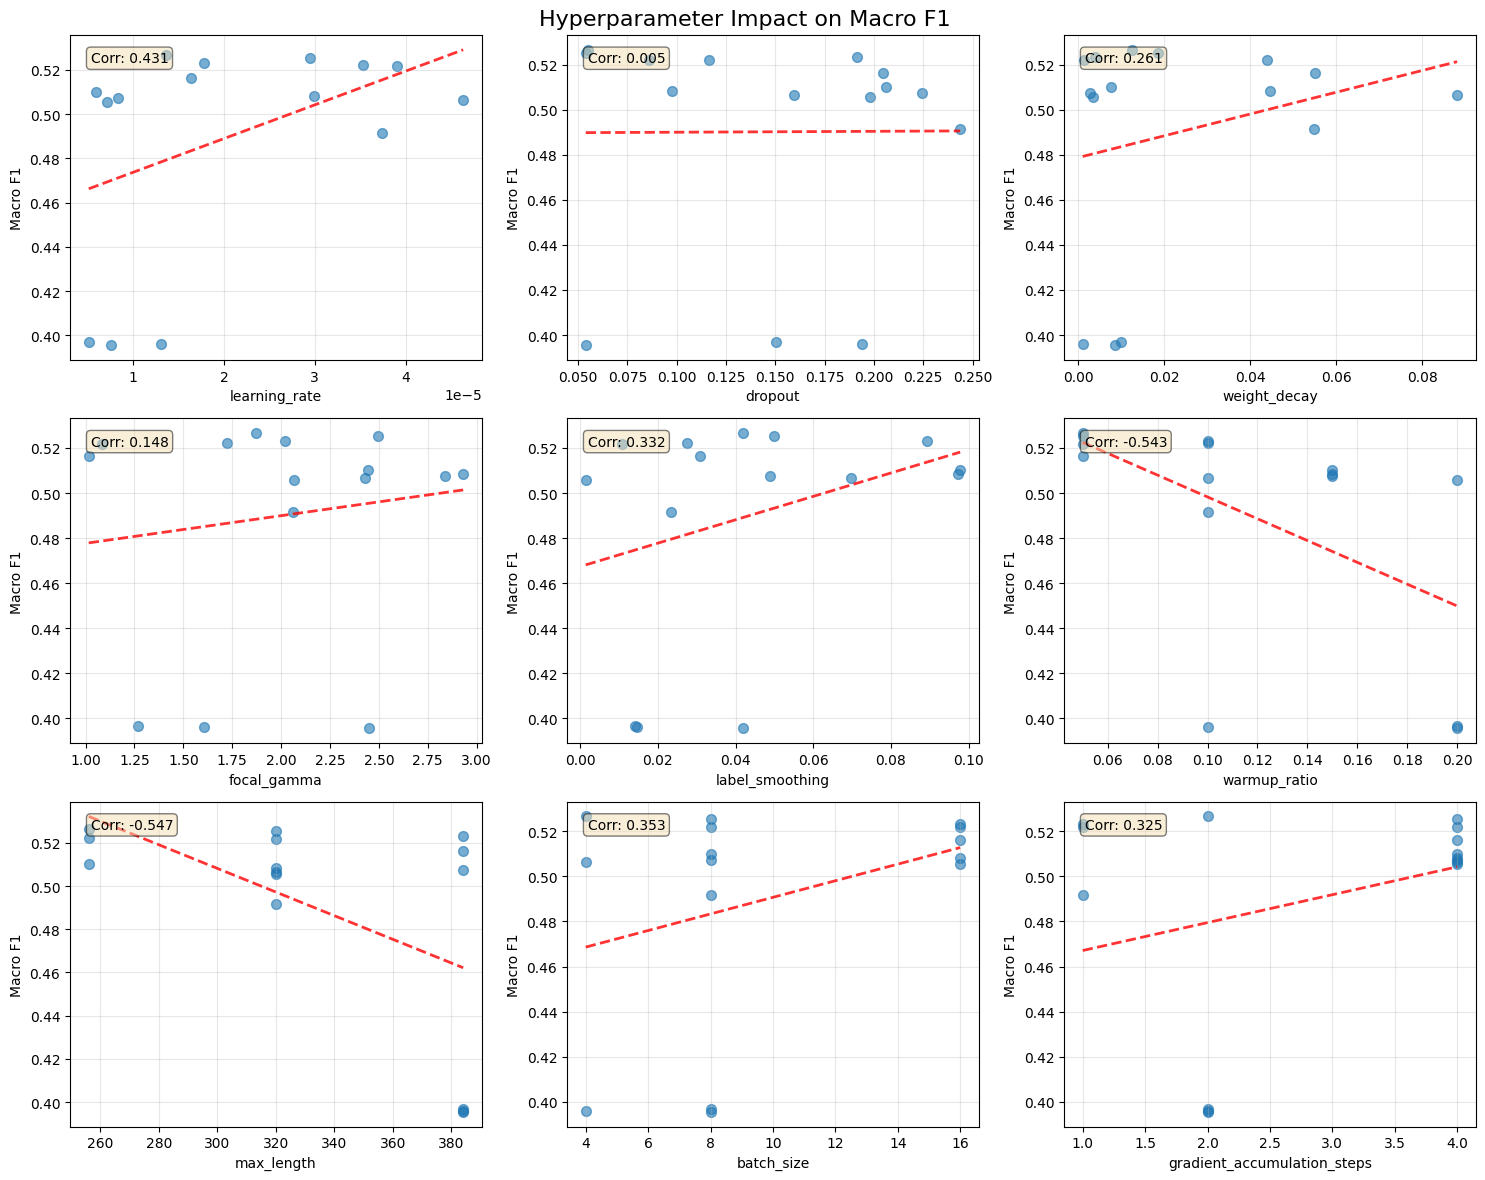

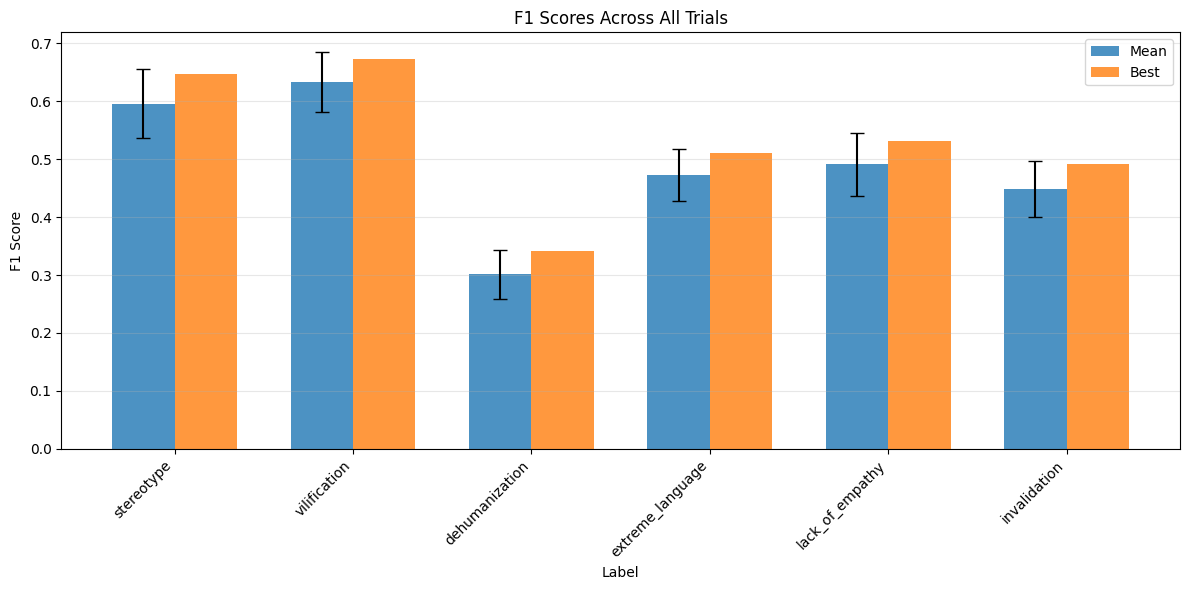

In [ ]:
"""
=============================================================================
ANALYZE HYPERPARAMETER SEARCH RESULTS
Visualize and understand parameter importance
=============================================================================
"""

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load results
with open('hyperparameter_search_results.json', 'r') as f:
    results = json.load(f)

print(f"Loaded {len(results)} trials")

# =============================================================================
# CREATE DATAFRAME
# =============================================================================
rows = []
for r in results:
    row = {
        'trial': r['trial'],
        'macro_f1': r['macro_f1'],
        **r['hyperparameters'],
        **{f'f1_{k}': v for k, v in r['per_label_f1'].items()}
    }
    rows.append(row)

df = pd.DataFrame(rows)

# =============================================================================
# SUMMARY STATISTICS
# =============================================================================
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)

print(f"\nMacro F1 - Mean: {df['macro_f1'].mean():.4f} ± {df['macro_f1'].std():.4f}")
print(f"Macro F1 - Range: [{df['macro_f1'].min():.4f}, {df['macro_f1'].max():.4f}]")
print(f"Improvement: {((df['macro_f1'].max() - df['macro_f1'].min()) / df['macro_f1'].min() * 100):.1f}%")

# =============================================================================
# CORRELATION ANALYSIS
# =============================================================================
print("\n" + "="*70)
print("PARAMETER IMPORTANCE (Correlation with Macro F1)")
print("="*70)

hp_columns = ['learning_rate', 'dropout', 'weight_decay', 'focal_gamma',
              'label_smoothing', 'warmup_ratio', 'max_length', 'batch_size',
              'gradient_accumulation_steps']

correlations = []
for col in hp_columns:
    if df[col].dtype in ['float64', 'int64'] and df[col].nunique() > 1:
        corr = df[col].corr(df['macro_f1'])
        correlations.append({'parameter': col, 'correlation': corr, 'abs_corr': abs(corr)})

corr_df = pd.DataFrame(correlations).sort_values('abs_corr', ascending=False)

print("\nMost Important Parameters:")
for _, row in corr_df.iterrows():
    sign = "+" if row['correlation'] > 0 else "-"
    print(f"  {row['parameter']:30s}: {sign} {abs(row['correlation']):.3f}")

# =============================================================================
# BEST CONFIGURATIONS BY PERCENTILE
# =============================================================================
print("\n" + "="*70)
print("PARAMETER RANGES IN TOP 25% vs BOTTOM 25%")
print("="*70)

top_25 = df.nlargest(int(len(df) * 0.25), 'macro_f1')
bottom_25 = df.nsmallest(int(len(df) * 0.25), 'macro_f1')

print(f"\nTop 25% Macro F1: {top_25['macro_f1'].mean():.4f}")
print(f"Bottom 25% Macro F1: {bottom_25['macro_f1'].mean():.4f}\n")

for col in hp_columns:
    if df[col].dtype in ['float64', 'int64']:
        top_mean = top_25[col].mean()
        bottom_mean = bottom_25[col].mean()
        diff = ((top_mean - bottom_mean) / bottom_mean * 100) if bottom_mean != 0 else 0

        print(f"{col:30s}:")
        print(f"  Top 25%:    {top_mean:.6f}" if isinstance(top_mean, float) and top_mean < 1 else f"  Top 25%:    {top_mean:.2f}")
        print(f"  Bottom 25%: {bottom_mean:.6f}" if isinstance(bottom_mean, float) and bottom_mean < 1 else f"  Bottom 25%: {bottom_mean:.2f}")
        print(f"  Difference: {diff:+.1f}%\n")

# =============================================================================
# VISUALIZATIONS
# =============================================================================
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Hyperparameter Impact on Macro F1', fontsize=16)

for idx, col in enumerate(hp_columns):
    ax = axes[idx // 3, idx % 3]

    if df[col].dtype in ['float64', 'int64']:
        # Scatter plot for continuous
        ax.scatter(df[col], df['macro_f1'], alpha=0.6, s=50)

        # Add trend line
        z = np.polyfit(df[col], df['macro_f1'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(df[col].min(), df[col].max(), 100)
        ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)

        ax.set_xlabel(col)
        ax.set_ylabel('Macro F1')
        ax.grid(True, alpha=0.3)

        # Add correlation
        corr = df[col].corr(df['macro_f1'])
        ax.text(0.05, 0.95, f'Corr: {corr:.3f}', transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                verticalalignment='top')
    else:
        # Box plot for categorical
        df.boxplot(column='macro_f1', by=col, ax=ax)
        ax.set_title('')
        ax.set_xlabel(col)
        ax.set_ylabel('Macro F1')

plt.tight_layout()
plt.savefig('hyperparameter_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Saved: hyperparameter_analysis.png")

# =============================================================================
# PER-LABEL ANALYSIS
# =============================================================================
fig, ax = plt.subplots(figsize=(12, 6))

label_cols = [c for c in df.columns if c.startswith('f1_')]
label_names = [c.replace('f1_', '') for c in label_cols]

# Calculate mean and std for each label
means = [df[col].mean() for col in label_cols]
stds = [df[col].std() for col in label_cols]
maxs = [df[col].max() for col in label_cols]

x = np.arange(len(label_names))
width = 0.35

ax.bar(x - width/2, means, width, label='Mean', alpha=0.8)
ax.bar(x + width/2, maxs, width, label='Best', alpha=0.8)
ax.errorbar(x - width/2, means, yerr=stds, fmt='none', color='black', capsize=5)

ax.set_xlabel('Label')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores Across All Trials')
ax.set_xticks(x)
ax.set_xticklabels(label_names, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('per_label_f1_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Saved: per_label_f1_analysis.png")

# =============================================================================
# RECOMMENDED CONFIGURATION
# =============================================================================
print("\n" + "="*70)
print("RECOMMENDED CONFIGURATION (Based on Analysis)")
print("="*70)

# Use mean of top 25%
recommended = {}
for col in hp_columns:
    if df[col].dtype in ['float64', 'int64']:
        recommended[col] = top_25[col].mean()
    else:
        # For categorical, use mode
        recommended[col] = top_25[col].mode()[0]

print("\nOptimized CONFIG dictionary:")
print("{")
for k, v in recommended.items():
    if isinstance(v, float):
        if v < 0.001:
            print(f"    '{k}': {v:.2e},")
        elif v < 1:
            print(f"    '{k}': {v:.4f},")
        else:
            print(f"    '{k}': {int(v)},")
    else:
        print(f"    '{k}': {v},")
print("}")

print("\n✨ Analysis complete!")

# 🔍 Hyperparameter Search - Quick Start Guide

## Overview
This random search will test **20 different configurations** to find the optimal hyperparameters for your DeBERTa model.

## What Gets Optimized

| Parameter | Current Value | Search Range | Type |
|-----------|---------------|--------------|------|
| **Learning Rate** | 1.5e-5 | 5e-6 to 5e-5 | Log-uniform |
| **Dropout** | 0.15 | 0.05 to 0.25 | Uniform |
| **Weight Decay** | 0.05 | 0.001 to 0.1 | Log-uniform |
| **Focal Gamma** | 2.0 | 1.0 to 3.0 | Uniform |
| **Label Smoothing** | 0.05 | 0.0 to 0.1 | Uniform |
| **Warmup Ratio** | 0.1 | [0.05, 0.1, 0.15, 0.2] | Choice |
| **Max Length** | 320 | [256, 320, 384] | Choice |
| **Batch Size** | 8 | [4, 8, 16] | Choice |
| **Gradient Accum** | 2 | [1, 2, 4] | Choice |

## How to Run

### Step 1: Run the Search (3-5 hours on GPU)
```python
# This will test 20 random configurations
python hyperparameter_search.py
```

**What happens:**
- Each trial trains a model with different hyperparameters
- Validation F1 scores are tracked
- Results saved after each trial (safe to interrupt)
- Best model from each trial is kept

### Step 2: Analyze Results
```python
# Generate visualizations and recommendations
python analyze_search_results.py
```

**Outputs:**
- `hyperparameter_search_results.json` - All trial data
- `hyperparameter_analysis.png` - Parameter importance plots
- `per_label_f1_analysis.png` - Performance by label
- Console output with best configuration

## Adjusting Search Settings

### To Run Fewer/More Trials
```python
# In hyperparameter_search.py
SEARCH_CONFIG = {
    'n_trials': 10,  # Change from 20 to 10 for faster results
    # ...
}
```

### To Focus on Specific Parameters
```python
# Comment out parameters you don't want to search
SEARCH_SPACE = {
    'learning_rate': (5e-6, 5e-5, 'log-uniform'),
    'dropout': (0.05, 0.25, 'uniform'),
    # 'weight_decay': (0.001, 0.1, 'log-uniform'),  # Skip this one
    # ...
}
```

### To Change Search Ranges
```python
# Make learning rate search narrower
'learning_rate': (1e-5, 3e-5, 'log-uniform'),  # Instead of (5e-6, 5e-5)
```

## Understanding Results

### Best Trial Output
```
BEST CONFIGURATION
Macro F1: 0.5234
Hyperparameters:
  'learning_rate': 2.3e-5,
  'dropout': 0.18,
  ...
```

### Parameter Importance
```
PARAMETER IMPORTANCE
  learning_rate      : + 0.452  <- Strong positive correlation
  dropout           : - 0.231  <- Lower dropout is better
  focal_gamma       : + 0.089  <- Weak positive correlation
```

**Interpretation:**
- **High correlation**: This parameter matters a lot
- **Positive (+)**: Higher values → better F1
- **Negative (-)**: Lower values → better F1

### Top 25% vs Bottom 25%
```
learning_rate:
  Top 25%:    0.000025
  Bottom 25%: 0.000012
  Difference: +108%
```
This shows the best models used roughly 2× higher learning rates.

## Tips for Better Results

### 1. **Start Small, Then Scale**
```python
# First run: 5-10 trials to get a sense
'n_trials': 10

# Second run: Focus on promising ranges with 20+ trials
'n_trials': 20
```

### 2. **Use Early Results to Narrow Search**
After 5 trials, if you see:
- All high F1 scores have `learning_rate` > 2e-5
- Narrow the range: `(2e-5, 5e-5, 'log-uniform')`

### 3. **Watch for Overfitting**
If validation F1 keeps dropping after epoch 2-3:
- Increase dropout
- Increase weight decay
- Reduce learning rate

### 4. **Per-Label Insights**
Some labels might benefit from different settings. Check:
```python
# In results
best['per_label_f1']
# {'stereotype': 0.62, 'vilification': 0.45, ...}
```
If one label is consistently low, consider:
- Class weights (not currently implemented)
- Different threshold per label (already done!)

## Expected Improvements

Based on your current results:
- **Baseline Macro F1**: ~0.52
- **Expected after search**: 0.55-0.58 (+5-10%)
- **Best case**: 0.60-0.62 (+15-20%)

The biggest gains typically come from:
1. Learning rate (±5%)
2. Dropout + Weight Decay (±3%)
3. Focal Gamma (±2%)

## After Finding Best Config

### Apply to Production
```python
CONFIG = {
    # Copy the recommended values from analysis
    'learning_rate': 2.3e-5,  # From search results
    'dropout': 0.18,
    'focal_gamma': 2.4,
    # ... other optimized values
    
    # Keep your fixed settings
    'model_name': 'microsoft/deberta-v3-base',
    'use_augmented_data': True,
    # ...
}
```

### Train Final Model
```python
# Run with best config and MORE epochs for final model
CONFIG['num_epochs'] = 10
python enhanced_deberta_pipeline.py
```

## Troubleshooting

### "CUDA out of memory"
```python
# Reduce batch size in search space
'batch_size': ([4, 8], 'choice'),  # Remove 16
```

### "Search taking too long"
```python
# Reduce trials
'n_trials': 10

# Reduce epochs
FIXED_CONFIG['num_epochs'] = 4

# Reduce early stopping patience
'early_stopping_patience': 3
```

### "No improvement found"
- Your current config might already be near-optimal!
- Try expanding search ranges
- Consider other strategies (ensemble models, different architectures)

## Next Steps

1. ✅ Run the search
2. ✅ Analyze results
3. ✅ Apply best config
4. ✅ Train final model with best settings
5. 🚀 Submit predictions and track leaderboard score!

Good luck! 🎯